<a href="https://colab.research.google.com/github/alibekk93/IDP_analysis/blob/main/IDP_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intrinsically disordered proteins in thermophilic bacteria

In this notebook we go through IDR prediction of various protein datasets and compare the IDR content of these datasets.

https://omabrowser.org/oma/genomePW/

https://github.com/dessimozlab/pyham

In [ ]:
# !git init

# %cd /content/IDP_analysis/

# !git add .

# !git config --global user.email "alibek.kruglikov11@gmail.com"
# !git config --global user.name "alibekk93"

# !git commit -m "Message"

# !git push https://<token>@github.com/alibekk93/IDP_analysis.git

## Setup

[Biopython](https://biopython.org/) package is used to read .fasta files and work with sequences. Other packages are used to process the data, connect with API services to predict IDR, download results, etc.

In [1]:
# copy repo to get available datafiles

!git clone https://github.com/alibekk93/IDP_analysis.git
!cd /content/IDP_analysis/

Cloning into 'IDP_analysis'...
remote: Enumerating objects: 1273, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 1273 (delta 99), reused 122 (delta 66), pack-reused 1099
Receiving objects: 100% (1273/1273), 552.86 MiB | 15.22 MiB/s, done.
Resolving deltas: 100% (587/587), done.
Updating files: 100% (72/72), done.


In [2]:
#@title # Packages installation and imports

# Biopython
!pip install BIO
from Bio import SeqIO, AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Align.Applications import ClustalwCommandline
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from Bio.SubsMat.MatrixInfo import blosum62
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils.ProtParamData import gravy_scales

# files uploading / downloading
from google.colab import files
import pickle
from io import StringIO

# statistics
!pip install --upgrade scipy
from scipy.stats import mannwhitneyu, chisquare, pearsonr, ttest_ind, ttest_rel, wilcoxon, ks_2samp
from sklearn.preprocessing import MinMaxScaler

# other packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm.contrib import tzip
tqdm.pandas()
from functools import reduce

# install ClustalW
!sudo apt-get update
!sudo apt-get install clustalw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 69.0 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2,136 kB]

In [3]:
#@title # Installing chromium without snap

#@markdown Ubuntu no longer distributes chromium-browser outside of snap

#@markdown Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap
%%shell

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF
# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg
# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500
Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300
Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

Executing: /tmp/apt-key-gpghome.9dUYY631ZC/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.w3MSGgrDvX/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.5w3AJpH30t/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [4]:
#@title # Setting up selenium webdriver

!apt-get update
!apt-get install chromium chromium-driver
!pip3 install selenium
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import urllib.request
import json

options = Options()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument('--disable-dev-shm-usage')
# driver = webdriver.Chrome("chromedriver", options=options)

Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Get:4 http://deb.debian.org/debian buster-updates InRelease [56.6 kB]
Get:5 http://deb.debian.org/debian-security buster/updates InRelease [34.8 kB]
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Get:9 http://deb.debian.org/debian buster/main amd64 Packages [10.7 MB]
Hit:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:13 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:14 http://ppa.

In [5]:
#@title # Setting up variables and loading species table

models = ['VLXT', 'VL3', 'VSL2', 'iupred3']
species_table = pd.read_excel('/content/IDP_analysis/datafiles/species.xlsx')
# linestyles = ['-', '--', '-', '--', '-.', ':']

## Functions

In [6]:
#@title ### Read fasta

def read_fasta(fasta_file: str) -> pd.DataFrame:
  """Processes raw .fasta files

  Opens a .fasta file, parses the sequences and their IDs into a
  dataframe and returns the dataframe.

  Parameters
  ----------
  fasta_file : str
    the raw .fasta file directory.
  
  Returns
  -------
  pd.DataFrame
    a dataframe with ID, Sequence and Length columns.

  """

  # open the file
  handle = open(fasta_file, 'r')
  seq_list = list(SeqIO.parse(handle, 'fasta'))
  handle.close()

  # parse data into lists
  ids = [seq_record.id.split('|')[1] for seq_record in seq_list]
  seqs = [str(seq_record.seq) for seq_record in seq_list]
  lens = [len(seq) for seq in seqs]

  # save data into a dataframe
  df = pd.DataFrame({'ID':ids, 'Sequence':seqs, 'Length':lens})

  return df

In [7]:
#@title ### Try-retreive url

def try_retrieve_url(url: str, filename: str):
  """A simple try / except pattern for urllib.request
  """

  try:
    return urllib.request.urlretrieve(url, filename)
  except:
    return np.nan

In [8]:
#@title ### Calculate IuPred3 disorder

def calculate_iupred(proteinID_list: list, score_only: bool=True) -> list:
  """Calculate protein IDR profile using IUPred3 REST API

  Creates URL based on protein UniProt accession numbers
  (from a list). Each IDR profile is saved as a JSON file
  and put into a list. The JSON files are then unpacked,
  either all data or only IUPred3 score are saved.

  Parameters
  ----------
  proteinID_list : list
    a list of protein accessions for which to predict IDR
  score_only : bool (default=True)
    whether the return should only contain IUPRed3 score.
    Other data are AA sequence, and a binary disorder
    prediction.

  Returns
  -------
  list
    a list of either IUPred3 scores or of all data from
    each JSON as a dictionary.

  """

  # make a list of URLs
  iupredURL_list = ['http://iupred3.elte.hu/iupred3/' + proteinID + '.json' \
                    for proteinID in proteinID_list]
  
  # download JSON files
  print('Retrieving disorder values from server...')
  protein_files = [try_retrieve_url(iupredURL, proteinID  + '.json')\
                   for iupredURL, proteinID in zip(tqdm(iupredURL_list),\
                                                        proteinID_list)]
  
  # empty list for unpacked JSON data
  proteins = []
  
  # populate the empty list
  print('Unpacking json files...')
  for proteinID in tqdm(proteinID_list):
    try:
      with open('/content/{}.json'.format(proteinID), 'r') as f:
        d = json.load(f)
        # check if only scores need to be saved
        if score_only == True:
          d = d['iupred2']
    except:
      d = np.nan
    proteins.append(d)
  
  return proteins

In [9]:
#@title ### Read pickle file

def read_pickle_file(file_name: str):
  """A simple function to read pickle files

  Parameters
  ----------
  file_name : srt
    location of the pickle file
  
  Returns
  -------
  any format, but best with pd.DataFrames or lists
  
  """

  print(file_name + ' loading...')
  with open(file_name, 'rb') as f:
    result = pickle.load(f)
  print(file_name + ' loaded!')
  return result

In [10]:
#@title ### Binary disorder

def binary_disorder(disorder_list: list, threshold: float=0.5) -> list:
  """Returns a list of binary values for disordered
  residues given a threshold

  Parameters
  ----------
  disorder_list : list
    a list of disorder values
  threshold : float
    a binary threshold, 0.5 by default. Disorder score
    above the threshold means that the residue is
    considered to be disordered
  
  Returns
  -------
  list
    a list of binary values indicating whether the
    residue is disordered (1) or not (0)
  
  """

  return [1 if dis > threshold else 0 for dis in disorder_list]

In [11]:
#@title ### Find longest binary IDR

def find_longest_binary_IDR(binary_disorder_list: list) -> int:
  """Finds the longest stretch of binary IDR for a
  given protein

  Parameters
  ----------
  binary_disorder_list : list
    a list of binary values indicating whether the
    residue is disordered (1) or not (0)
  
  Returns
  -------
  int
    a number of disordered residues in the longest
    IDR
  
  """

  # set max IDR length as zero
  max_IDR_len = 0

  # set current IDR length as zero
  current_IDR_len = 0
  # iterate though each residue
  for disorder in binary_disorder_list:
    if disorder == 1:
      # increase current IDR length if disordered
      current_IDR_len += 1
    else:
      # not part of IDR, save current length if max or continue
      if current_IDR_len > max_IDR_len:
        max_IDR_len = current_IDR_len
      current_IDR_len = 0

  return max_IDR_len

In [12]:
#@title ### Get PONDR disorder calculations

def get_pondr_calculations(protein_ID: str, sequence: str, return_df: bool=True):
  """Uses Selenium to scrape PONDR disorder
  calculations for a given protein

  Parameters
  ----------
  protein_ID : str
    protein ID or name. Required by PONDR,
    but has no effect on result
  sequence : str
    AA sequence of the protein
  return_df : bool
    whether return should be a DataFrame
    (True) or a tuple of lists (False). True
    by default
  
  Returns:
  --------
  DataFrame or tuple with lists

  """

  # set up web driver to get data from pondr.com
  wd = webdriver.Chrome(options=options)
  wd.get('http://www.pondr.com/')
  # set options and submit
  wd.find_element(By.NAME, 'ProteinName').send_keys(protein_ID)
  wd.find_element(By.NAME, 'Sequence').send_keys(sequence)
  wd.find_element(By.NAME, 'VL3').click()
  wd.find_element(By.NAME, 'VSL2').click()
  wd.find_element(By.NAME, 'wcwraw').click()
  wd.find_element(By.NAME, 'submit_result').click()
  # paste the raw results table to a DataFrame
  try:
    table = wd.find_elements(By.TAG_NAME, 'pre')[-1]
    table_text = table.text
    disorder_df = pd.read_csv(StringIO(table_text.replace('  ', ' ')), sep=' ')[['VLXT', 'VL3', 'VSL2']]
  except:
    disorder_df = pd.DataFrame(columns=['VLXT', 'VL3', 'VSL2'])
  if return_df == True:
    return disorder_df
  else:
    return [*disorder_df['VLXT']], [*disorder_df['VL3']], [*disorder_df['VSL2']]

In [13]:
#@title ### Fix -infinitives

def fix_neg_inf(df: pd.DataFrame, replacement=np.nan) -> pd.DataFrame:
  """Replaces -inf values in a given dataframe

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe with -inf to be replaced
  replacement
    The value to replace -inf with. Default
    is np.nan
  
  Returns:
  --------
  pd.DataFrame

  """

  df_new = df.copy()
  df_new[df.astype(float) < 0] = replacement
  return df_new

In [14]:
#@title ### Align sequences

def align_seqs(seqs: list, ids: list, gap_ins_pen: float=-1.0,
               gap_ext_pen: float=-0.5):
  """Multiple sequence alignment using ClustalW

  Parameters
  ----------
  seqs : list
    A list of sequences to be aligned (as str)
  ids : list
    A list of sequence IDs (as str)
  gap_ins_pen : float
    Gap insertion penalty for the alignment.
    -1.0 by default
  gap_ext_pen : float
    Gap extension penalty for the alignment.
    -0.5 by default
  
  Returns
  -------
  Alignment object

  """

  # create seq records
  records = [SeqRecord(Seq(seq), id) for seq, id in zip(seqs, ids)]
  # save records as fasta
  with open('unaligned.fas', 'w') as handle:
    SeqIO.write(records, handle, 'fasta')
  # align using ClustalW
  cline = ClustalwCommandline(infile='unaligned.fas', outfile='aligned.fas',
                            gapext=gap_ext_pen, gapopen=gap_ins_pen,
                            type='PROTEIN', outorder='INPUT',
                            output='FASTA')
  cline()
  # read the output file
  align = AlignIO.read('aligned.fas', 'fasta')
  return align

In [18]:
#@title ### Align disorder

def align_disorder(disorder_values: list, seqs: list, ids: list,
                  gap_ins_pen: float=-1.0, gap_ext_pen: float=-0.5) -> tuple:
  """Aligns disorder values based on AA sequences

  Parameters:
  -----------
  disorder_values : list
    A list of disorder values to be plotted
  seqs : list
    A list of sequences to be aligned
  ids : list
    A list of sequence IDs (as str)
  gap_ins_pen : float
    Gap insertion penalty for the alignment.
    -1.0 by default
  gap_ext_pen : float
    Gap extension penalty for the alignment.
    -0.5 by default

  Returns:
  --------
  (sequence_alignment, disorder_alignment)

  """

  aligned_disorders = []
  # align sequences
  alignment = align_seqs(seqs, ids, gap_ins_pen=gap_ins_pen, gap_ext_pen=gap_ext_pen)
  # insert gaps in disorder values
  for a, d in zip(alignment, disorder_values):
    seq_disorder_full = [*d.copy()]
    for i, residue in enumerate(a.seq):
      if residue == '-':
        seq_disorder_full.insert(i, np.nan)
    seq_disorder_full = pd.Series(seq_disorder_full).interpolate().tolist()
    aligned_disorders.append(seq_disorder_full)
  return (alignment, aligned_disorders)

In [ ]:
#@title ### Plot IDP profile OLD

def plot_IDR_profile_OLD(disorder_values: list, seqs: list, labels: list,
                     colors: list, linestyles: list, names: list=None,
                     mav: int=1, scale_mav=False, gap_ins_pen: float=-1.0,
                     gap_ext_pen: float=-0.5, savefig=False) -> None:
  """Plots an aligned IDR profile for proteins given
  their disorders and sequences lists

  Parameters
  ----------
  disorder_values : list
    A list of disorder values to be plotted
  seqs : list
    A list of sequences to be aligned
  labels : list
    A list of labels for the plot legend
  names : list
    A list of titles to be plotted. Is not
    required, but makes plot better
  mav : int
    Moving average value. 1 by default,
    which plots original values
  scale_mav : bool
    Whether mav should be scaled based on
    protein length. If True, original mav
    value would be multiplied by
    len(protein) / 500. False by default
  gap_ins_pen : float
    Gap insertion penalty for the alignment.
    Default penalty is -1
  gap_ext_pen : float
    Gap extension penalty for the alignment.
    Default penalty is -0.5
  savefig : bool
    Whether the figure should be saved.
    False by default
  
  Returns:
  --------
  No return, makes a plot

  """

  # make the alignment
  aligned_disorders = []
  alignment = align_seqs(seqs, labels, gap_ins_pen=gap_ins_pen, gap_ext_pen=gap_ext_pen)
  for a, d in zip(alignment, disorder_values):
    seq_disorder_full = [*d.copy()]
    for i, residue in enumerate(a.seq):
      if residue == '-':
        seq_disorder_full.insert(i, np.nan)
    seq_disorder_full = pd.Series(seq_disorder_full).interpolate().tolist()
    aligned_disorders.append(seq_disorder_full)
  # plot values
  fig, ax = plt.subplots(figsize=(15, 8))
  # check for title
  if names != None:
    title = ''.join([n + ' : ' for n in names])
    fig.suptitle(title, fontsize=20)
  # Scale mav if needed
  if scale_mav == True:
    mav = int(np.round(mav * len(aligned_disorders[0]) / 500))
  # plot
  ax.set_ylim(0, 1)
  ax.set_xlabel('Position in sequence', fontsize=18)
  ax.set_ylabel('Predicted disorder', fontsize=18)
  ys = [np.convolve(ad, np.ones(mav)/mav) for ad in aligned_disorders]
  x = np.arange(0, len(ys[0]))
  for i, y in enumerate(ys):
    # cut extra mav values
    cut = int(mav / 2)
    # plot the values
    ax.plot(y[cut:len(y)-cut+1], c=colors[i], linestyle=linestyles[i], label='$\\it{}$'.format(labels[i]))
  # ax.fill_between(x, y1, y2, where = y1 > y2, facecolor ='red', alpha = 0.3)
  # ax.fill_between(x, y1, y2, where = y2 > y1, facecolor ='green', alpha = 0.3)
  # ax.legend(loc='upper left')
  pos = ax.get_position()
  ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
  ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
  ax.axhline(0.5, ls='--', c='black')
  # check if needs to be saved
  if savefig == True:
    if names == None:
      raise ValueError('Sequence names not provided')
    fig.savefig(title + '.svg')

In [ ]:
#@title ### Get charge / hydrophobicity

def get_charge_hydrophobicity(seq: str) -> tuple:
  """Calculates mean absolute charge and hydrophobicity
  
  Parameters
  ----------
  seq : str
    AA sequence to calculate values for
  
  Returns:
  --------
  tuple
    tuple with two float values:
    1) mean absolute charge
    2) mean hydrophobicity (scaled 0-1)

  """

  # calculate mean absolute charge
  prot_analysis = ProteinAnalysis(seq)
  mean_abs_charge = abs(prot_analysis.charge_at_pH(7)) / prot_analysis.length

  # get Kyle-Doolitle scale
  KyteDoolitle = gravy_scales.get('KyteDoolitle', -1)
  KyteDoolitle['X'] = 0
  KyteDoolitle['U'] = 0
  # normalize scale to 0-1 range
  scaler = MinMaxScaler()
  KD_norm = {k:v[0] for k, v in zip(KyteDoolitle.keys(), scaler.fit_transform(np.array([*KyteDoolitle.values()]).reshape(-1, 1)))}
  # calculate mean hydrophobicity
  hydrophobicity_sum = sum(KD_norm[aa] for aa in seq)
  mean_hydrophobicity = hydrophobicity_sum / prot_analysis.length
  
  return mean_abs_charge, mean_hydrophobicity

In [ ]:
#@title ### Drop unavailable rows

def drop_unavailable(proteome: pd.DataFrame, reset_index: bool=True) -> pd.DataFrame:
  """Drop rows if not all models are available

  """

  mask = [proteome.disorder.iloc[n].shape[1]==4 for n in range(len(proteome))]
  proteome = proteome[mask]
  if reset_index == True:
    proteome.reset_index(inplace=True, drop=True)
  return proteome

In [ ]:
#@title ### Load / Create IUPred3 disorder values file

def try_load_create_iupred_disorder_file(species_tag:str, proteome:pd.DataFrame, download:bool=False) -> None:
  """Try to load IUPred3 disorder values
  This function attempts to load IUPred3 disorder values from a file and if it's not available, 
  it calculates IUPred3 disorder values using the `get_pondr_calculations` function and stores the values in a file.
  -----------
  Parameters:
  species_tag (str): The species tag used to identify the file name.
  proteome (pd.DataFrame): The dataframe containing protein information.
  download (bool): A flag to indicate if the file should be downloaded. Defaults to False.
  
  Returns:
  None
  """

  # get file name
  file_name = '/content/IDP_analysis/datafiles/disorder/iupred3/{}_disorder_iupred3.pkl'.format(species_tag)
  # try to load IUPred3 disorder values file
  try:
    disorder_iupred3 = read_pickle_file(file_name)
    print('***{} IUPred file loaded!'.format(species_tag))
    # add disorder values to the dataframe
    proteome['disorder_iupred3'] = disorder_iupred3
    return
  except:
    print('***{} IUPred3 data are not available, loading from API...'.format(species_tag))
    # calcuate IUPred3 disorder
    disorder_iupred3 = calculate_iupred(proteome.ID)
    # add IUPred3 disorder values to the dataframe
    proteome['disorder_iupred3'] = disorder_iupred3
    # save the IUPred3 disorder list for future
    with open(file_name, 'wb') as f:
      pickle.dump(disorder_iupred3, f)
    if download:
      files.download(file_name)
    return

In [ ]:
#@title ### Load / Create PONDR disorder values file

def try_load_create_pondr_disorder_file(species_tag:str, proteome:pd.DataFrame, download:bool=False) -> None:
  """Try to load PONDR disorder values
  This function attempts to load PONDR disorder values from a file and if it's not available, 
  it calculates PONDR disorder values using the `calculate_pondr` function and stores the values in a file.
  -----------
  Parameters:
  species_tag (str): The species tag used to identify the file name.
  proteome (pd.DataFrame): The dataframe containing protein information.
  download (bool): A flag to indicate if the file should be downloaded. Defaults to False.
  
  Returns:
  None
  """

  # get file name
  file_name = '/content/IDP_analysis/datafiles/disorder/pondr/{}_disorder_pondr.pkl'.format(species_tag)
  # try to load PONDR disorder values file
  try:
    disorder_pondr = read_pickle_file(file_name)
    print('***{} PONDR file loaded!'.format(species_tag))
    # add disorder values to the dataframe
    proteome['disorder_pondr'] = disorder_pondr
    return
  except:
    print('***{} PONDR data are not available, getting from server...'.format(species_tag))
    # calcuate PONDR disorder
    disorder_pondr = [get_pondr_calculations(id, seq) for id, seq in tzip(proteome.ID, proteome.Sequence)]
    # add PONDR disorder values to the dataframe
    proteome['disorder_pondr'] = disorder_pondr
    proteome.dropna(inplace=True)
    # save the PONDR disorder list for future
    with open(file_name, 'wb') as f:
      pickle.dump(disorder_pondr, f)
    if download:
      files.download(file_name)
    return

In [ ]:
#@title ### Combine disorder values

def combine_disorder_values(species_tag:str, proteome:pd.DataFrame, download:bool=False) -> None:
  """Combine PONDR and IUPred3 disorder values
  Saves all values as a nested DataFrame 
  -----------
  Parameters:
  species_tag (str): The species tag used to identify the file name.
  proteome (pd.DataFrame): The dataframe containing protein information.
  download (bool): A flag to indicate if the file should be downloaded. Defaults to False.
  
  Returns:
  None
  """

  # set file name
  file_name = '/content/IDP_analysis/datafiles/completed/{}_proteome.pkl'.format(species_tag)
  proteome['disorder'] = proteome.disorder_pondr.copy()
  for i in range(len(proteome)):
    try:
      proteome.disorder.iloc[i]['iupred3'] = proteome.disorder_iupred3.iloc[i]
    except:
      proteome.disorder.iloc[i] = pd.DataFrame({'iupred3':proteome.disorder_iupred3.iloc[i]})
  proteome.drop(['disorder_iupred3', 'disorder_pondr'], axis=1, inplace=True)
  # save the complete proteome file
  proteome = drop_unavailable(proteome)
  proteome.to_pickle(file_name)
  if download:
    files.download(file_name)
  return

In [ ]:
#@title ### Get additional columns with IDP data

def get_additional_columns(proteome:pd.DataFrame) -> None:
  """Add Additional Columns to Proteome DataFrame
  This function calculates additional columns for the proteome DataFrame including:

  disorder_combined: mean of all disorder models
  disorder_binary: binary disorder values based on a threshold of 0.5
  disorder_mean: mean disorder score for each protein
  disorder_binary_mean: mean binary disorder value (fraction of disorder) for each protein
  longest_IDR: length of the longest binary intrinsically disordered region for each protein
  -----------
  Parameters:
  proteome (pd.DataFrame): The dataframe containing protein information.

  Returns:
  None
  """

  # get means of all models
  proteome['disorder_combined'] = [np.mean(proteome.disorder.iloc[i], axis=1) for i in range(len(proteome))]
  # get binary disorder values
  proteome['disorder_binary'] = proteome.disorder_combined.apply(binary_disorder, threshold=0.5)
  # get mean disorder values for each protein (mean disorder score)
  proteome['disorder_mean'] = proteome.disorder_combined.apply(np.mean)
  # get mean binary disorder values for each protein (fraction of disorder)
  proteome['disorder_binary_mean'] = proteome.disorder_binary.apply(np.mean)
  # find longest binary IDR for each protein
  proteome['longest_IDR'] = proteome.disorder_binary.apply(find_longest_binary_IDR)
  return

## Obtaining disorder predictions

In [ ]:
proteomes = {} # to store results of the loop

for i in range(len(species_table)):
  tag = species_table.species_tag[i]
  color = species_table.color[i]
  group = species_table.group[i]
  # read .fasta files and filter out short sequences (under 20 AA)
  # short sequences do not get processed by IDR predictors
  proteome_fasta = read_fasta(f'/content/IDP_analysis/datafiles/fastas/proteome_{tag}.fasta')
  proteome_fasta = proteome_fasta[proteome_fasta.Length > 19]
  # load existing files / get disorders from the web
  ## get filenames
  completed_filename = f'/content/IDP_analysis/datafiles/completed/{tag}_proteome.pkl'
  disorder_iupred3_filename = f'{tag}_disorder_iupred3.pkl'
  ## try to load the dataframe with disorder values
  try:
    proteome_fasta = read_pickle_file(completed_filename)
    print(f'{tag} proteome file loaded!')
    proteome_fasta = drop_unavailable(proteome_fasta)
  except:
    print(f'Completed {tag} proteome dataframe is not available, checking for individual predictor files...')
    ## try to load IUPred3 disorder values file
    try_load_create_iupred_disorder_file(tag, proteome_fasta, False)
    ## try to load PONDR disorder values file
    # try_load_create_pondr_disorder_file(tag, proteome_fasta, True)
    ## combine disorder values
    proteome_fasta.dropna(inplace=True)
    proteome_fasta['mean_disorder_score'] = proteome_fasta['disorder_iupred3'].apply(np.mean)
    proteome_fasta['binary_disorder'] = proteome_fasta['disorder_iupred3'].apply(binary_disorder)
    proteome_fasta['fraction_of_disorder'] = proteome_fasta['binary_disorder'].apply(np.mean)
    proteome_fasta['species_tag'] = tag
    proteome_fasta['group'] = group
    proteome_fasta['color'] = color
    # combine_disorder_values(tag, proteome_fasta, True)
  # On rare occasions disorder values can be -inf or other negative, 
  # which makes no sense. We will replace these with NaNs
  # proteome_fasta.disorder = proteome_fasta.disorder.progress_apply(fix_neg_inf)
  # add additional disorder columns
  # get_additional_columns(proteome_fasta)
  # store results in dictionary
  proteomes[tag] = proteome_fasta

proteomes_df = pd.concat(proteomes.values())

## OmaBrowser


We will need to process the dataframe:

1.   The acession numbers sometimes contain OMA genome names
2.   We only need 1:1 type of orthology
3.   The OMA_group column is not needed for this analysis

Some IDs from OMA contain not only UniProt ID, but also species ID. For example, *T. thermophilus* acession numbers sometimes contain "_THET8" **after** the actual number and *E. coli* sometimes contain "_ECOLX" **after** or "ECOLI" **before**. We will need to remove these from the strings to make sure all of the acession numbers can be used together with the rest of our data.

In [ ]:
#@title ### Get and process pairwise OMA file

def get_OMA(species_tag:str, common_species_tag:str='THET8', oma_type:str='any') -> pd.DataFrame:
  """Obtains pairwise OMA and returns a dataframe

  -----------
  Parameters:
  species_tag (str): Tag for species to use in OMA.
  common_species_tag (str): Tag for the second species to use in OMA. This should be the same
  for all OMA files. 'THET8' by default.
  oma_type (str): Type of OMA relationships to keep. 'any' by default. Other possibilities are
  '1:1', 'n:1', 'm:1' and 'n:m'

  Returns:
  pd.DataFrame
  """

  # get file
  path = f'https://omabrowser.org/cgi-bin/gateway.pl?f=PairwiseOrthologs&p1={common_species_tag}&p2={species_tag}&p3=UniProt'
  try_retrieve_url(path, '_')
  OMA = pd.read_csv('_', sep='\t')
  # process file
  OMA.columns = [common_species_tag, species_tag, 'oma_type', 'OMA_group']
  if oma_type != 'any':
    OMA = OMA[OMA['oma_type'] == oma_type]
  OMA.drop(['OMA_group', 'oma_type'], axis='columns', inplace=True)
  OMA[common_species_tag] = OMA[common_species_tag].str.replace(common_species_tag, '')
  OMA[common_species_tag] = OMA[common_species_tag].str.replace('_', '')
  OMA = OMA[OMA[common_species_tag].str.len()==6]
  OMA[species_tag] = OMA[species_tag].str.replace(species_tag, '')
  OMA[species_tag] = OMA[species_tag].str.replace('_', '')
  OMA.reset_index(inplace=True, drop=True)
  return OMA

In [ ]:
OMA_dfs = {}

# load OMAs
for tag in tqdm(species_table.species_tag):
  if tag != 'THET8':
    OMA_dfs[tag] = get_OMA(tag, oma_type='1:1')

# merge all DataFrames into one
OMA_combined = reduce(lambda  left, right: pd.merge(left, right, on=['THET8'], how='inner'), OMA_dfs.values())
OMA_combined = OMA_combined.drop_duplicates()

In [ ]:
proteomes_df['orthologs_cluster'] = 0

for i in OMA_combined.index:
  cluster = i + 1
  proteins = OMA_combined.iloc[i].values
  proteomes_df.loc[proteomes_df.ID.isin(proteins), 'orthologs_cluster'] = cluster

In [ ]:
first_merge_df = proteomes['THET8'].add_prefix('THET8_')
orthologs_df = pd.merge(left=first_merge_df, right=OMA_combined, left_on='THET8_ID', right_on='THET8', how='inner')
orthologs_df.drop(['THET8'], axis='columns', inplace=True)

for tag in species_table.species_tag:
  if tag != 'THET8':
    prefixed_df = proteomes[tag].add_prefix(f'{tag}_')
    orthologs_df = pd.merge(left=prefixed_df, right=orthologs_df, left_on=f'{tag}_ID', right_on=tag, how='inner')
    orthologs_df.drop([tag], axis='columns', inplace=True)

In [ ]:
orthologs_df_FOD = orthologs_df[orthologs_df.columns[orthologs_df.columns.str.endswith('fraction_of_disorder')]]
orthologs_df_MDS = orthologs_df[orthologs_df.columns[orthologs_df.columns.str.endswith('mean_disorder_score')]]

In [ ]:
orthologs_df_FOD['SD'] = orthologs_df_FOD.std(axis=1)
orthologs_df_MDS['SD'] = orthologs_df_MDS.std(axis=1)

In [ ]:
orthologs_df_MDS.SD.sort_values().plot(kind='bar')

## Visualisation and statistical analysis



### Entire proteomes

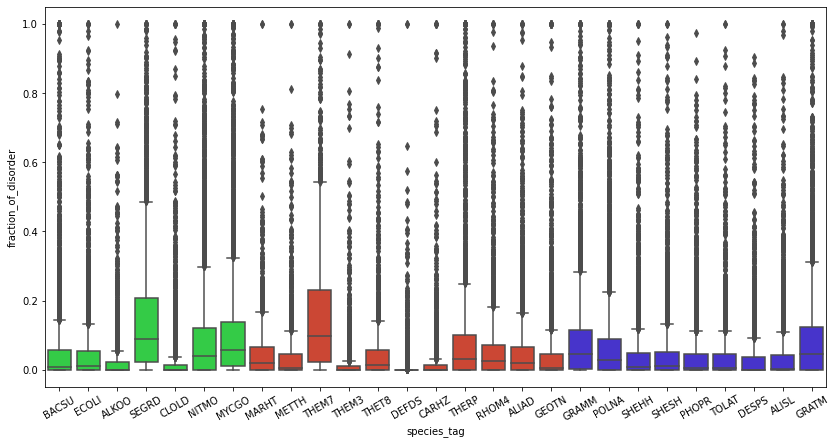

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
bp_mds = sns.boxplot(data=proteomes_df, x='species_tag', y='fraction_of_disorder', palette=species_table.color)
bp_mds.set_xticklabels(bp_mds.get_xticklabels(), rotation=30)
fig.show()

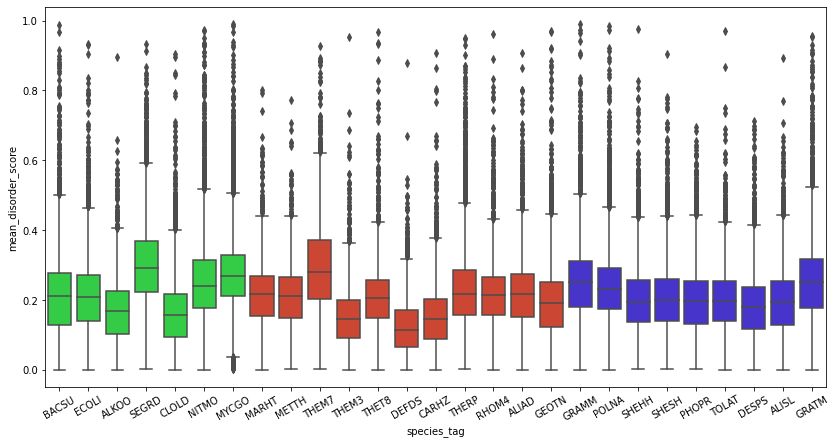

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
bp_mds = sns.boxplot(data=proteomes_df, x='species_tag', y='mean_disorder_score', palette=species_table.color)
bp_mds.set_xticklabels(bp_mds.get_xticklabels(), rotation=30)
fig.show()

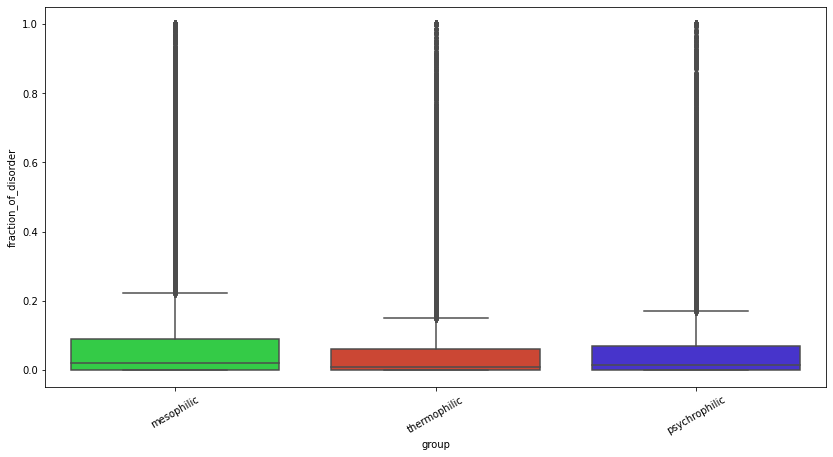

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
bp_mds = sns.boxplot(data=proteomes_df, x='group', y='fraction_of_disorder', palette=['#1BE434', '#E4341B', '#341BE4'])
bp_mds.set_xticklabels(bp_mds.get_xticklabels(), rotation=30)
plt.show()

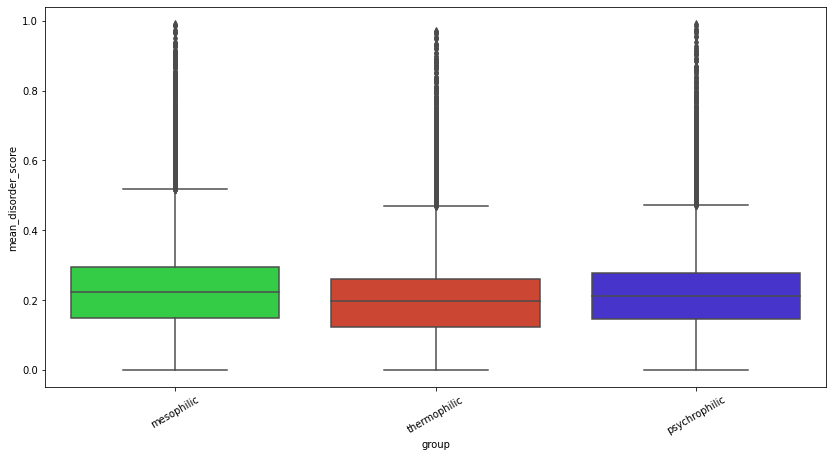

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
bp_mds = sns.boxplot(data=proteomes_df, x='group', y='mean_disorder_score', palette=['#1BE434', '#E4341B', '#341BE4'])
bp_mds.set_xticklabels(bp_mds.get_xticklabels(), rotation=30)
plt.show()

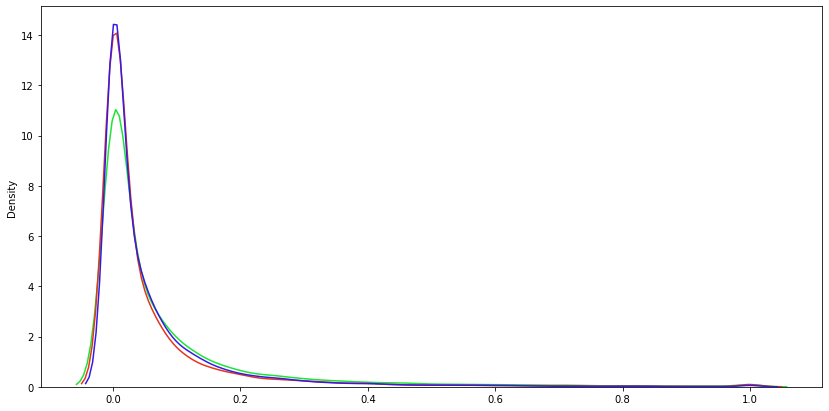

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
bp_mds = sns.kdeplot(proteomes_df[proteomes_df.group=='mesophilic'].fraction_of_disorder.values, c='#1BE434')
bp_mds = sns.kdeplot(proteomes_df[proteomes_df.group=='thermophilic'].fraction_of_disorder.values, c='#E4341B')
bp_mds = sns.kdeplot(proteomes_df[proteomes_df.group=='psychrophilic'].fraction_of_disorder.values, c='#341BE4')
fig.show()

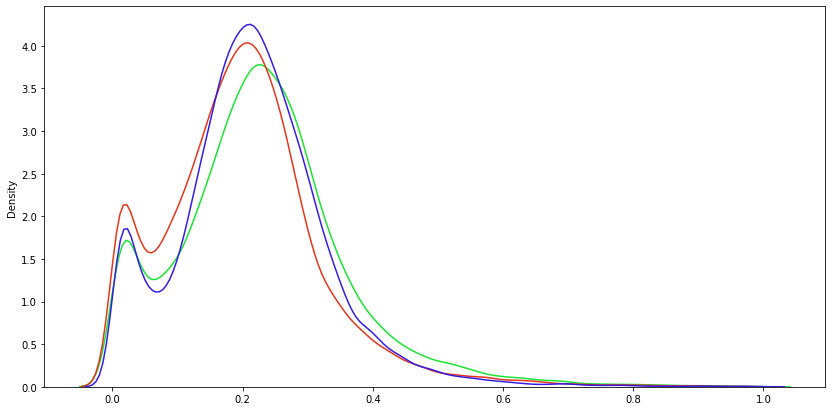

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
bp_mds = sns.kdeplot(proteomes_df[proteomes_df.group=='mesophilic'].mean_disorder_score.values, c='#1BE434')
bp_mds = sns.kdeplot(proteomes_df[proteomes_df.group=='thermophilic'].mean_disorder_score.values, c='#E4341B')
bp_mds = sns.kdeplot(proteomes_df[proteomes_df.group=='psychrophilic'].mean_disorder_score.values, c='#341BE4')
fig.show()

In [ ]:
species_table.color.unique()

array(['#1BE434', '#E4341B', '#341BE4'], dtype=object)

### Orthologs

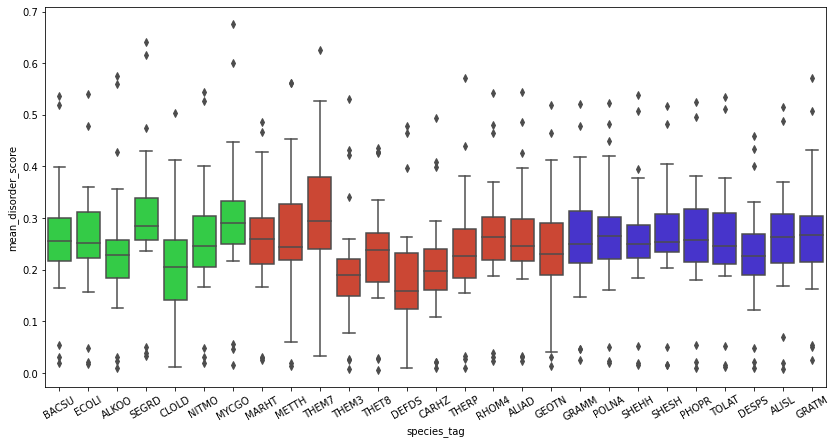

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
bp_mds = sns.boxplot(data=proteomes_df.query("orthologs_cluster != 0"), x='species_tag', y='mean_disorder_score', palette=species_table.color)
bp_mds.set_xticklabels(bp_mds.get_xticklabels(), rotation=30)
fig.show()

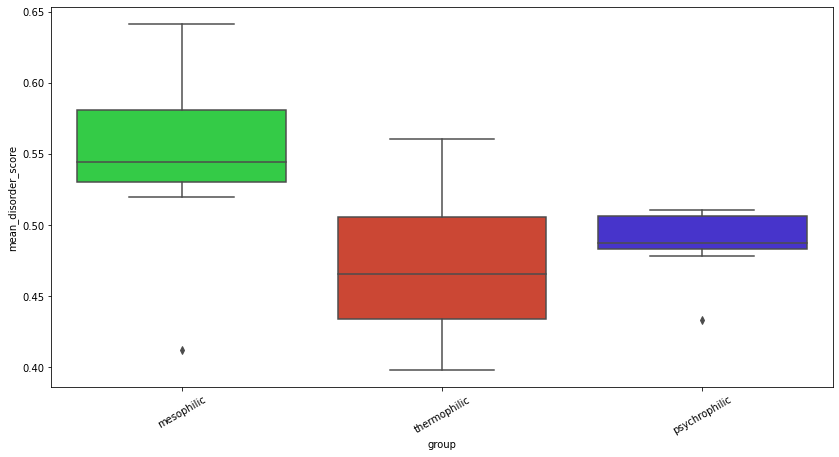

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
bp_mds = sns.boxplot(data=proteomes_df.query("orthologs_cluster == 25"), x='group', y='mean_disorder_score', palette=['#1BE434', '#E4341B', '#341BE4'])
bp_mds.set_xticklabels(bp_mds.get_xticklabels(), rotation=30)
plt.show()

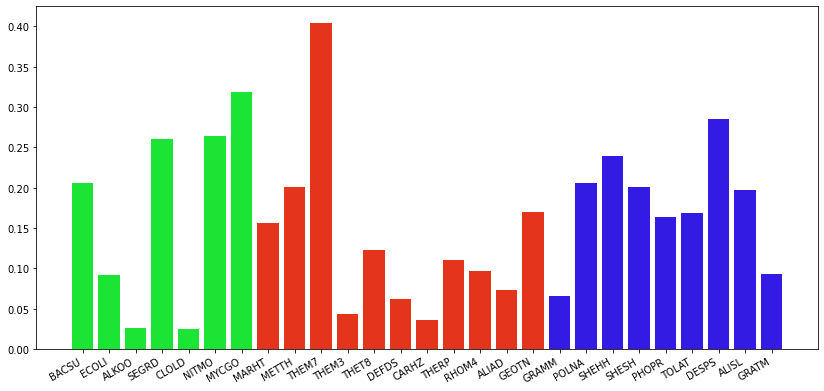

In [ ]:
data = proteomes_df[proteomes_df.orthologs_cluster == 10]

fig, ax = plt.subplots(figsize=(14,7))
ax.bar(x=data.species_tag, height=data.fraction_of_disorder, color=data.color)
# ax.set_ylim(0, 0.8)
fig.autofmt_xdate()
fig.show()

In [ ]:
proteomes_df.groupby('orthologs_cluster').std()[['fraction_of_disorder', 'mean_disorder_score']]

fraction_of_disorder  mean_disorder_score
orthologs_cluster                                           
0                              0.131420             0.122686
1                              0.025049             0.054709
2                              0.032081             0.046011
3                              0.002609             0.014466
4                              0.038165             0.029300
5                              0.036535             0.053844
6                              0.016526             0.036705
7                              0.016735             0.028422
8                              0.009928             0.010747
9                              0.036583             0.034177
10                             0.097049             0.060483
11                             0.049984             0.043353
12                             0.043093             0.062937
13                             0.056092             0.053401
14                             0.052330             0.043938
15                             0.061115             0.059655
16                             0.044411             0.040197
17                             0.076892             0.063752
18                             0.173461             0.064146
19                             0.042382             0.031322
20                             0.001303             0.012161
21                             0.094810             0.068816
22                             0.057413             0.055168
23                             0.006820             0.024739
24                             0.083058             0.079070
25                             0.123322             0.057331
26                             0.099921             0.045407
27                             0.020696             0.029790
28                             0.034754             0.026701

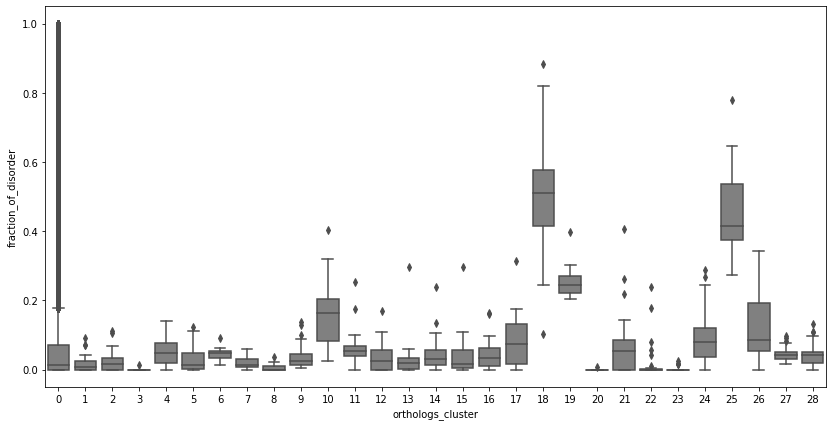

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
bp_mds = sns.boxplot(data=proteomes_df, x='orthologs_cluster', y='fraction_of_disorder', color='gray')
# bp_mds.set_xticklabels(bp_mds.get_xticklabels(), rotation=30)
fig.show()

In [ ]:
proteomes_df[proteomes_df.orthologs_cluster==10]

ID                                           Sequence  Length  \
1266      P31104  MRYLTAGESHGPQLTTIIEGVPAGLYITEEDINFELARRQKGHGRG...     390   
811       P12008  MAGNTIGQLFRVTTFGESHGLALGCIVDGVPPGIPLTEADLQHDLD...     361   
70        A8MH14  MLRYLSAGESHGKGLIAIIEGLPSNIPMDINRINADLGRRQQGFGR...     384   
73        D6Z8V2  MKNVLRWTTAGESHGRALIALLEGMVAGVAVTSEDVGGQLARRRLG...     403   
151       D8GP84  MSGMWGNKIKLSIFGESHGKAIGIVIDGLKAGTEIDLEYIRKQMKR...     360   
114   A0A0K2GA01  MAGNTFGHLFTVTSFGESHGPALGCVVDGCPPGLALSAEDIQKDLD...     386   
151   A0A0Q2R0V0  MLRWITAGESHGRALVAMVEGMVAGVEVTSTEIADELARRRLGYGR...     402   
198       F2NQR4  MRFLTAGESHGPQLTGVIEGLPAGLPLTPDEINPWLARRQGGYGRG...     383   
379       O26843  MILCGDSVAGNSTGEMFRVTTFGSSHGPAVGAVIDGCPAGLELSED...     374   
212       E6SM13  MTLRLLTAGESHGPGLVAVLEGIPYGLPLTTADIDRDLARRQLGYG...     571   
82        D7APX2  MRYITAGESHGEALIAVIEGLPANLLIDEDFINKELKRRQGGHGRG...     350   
239       Q5SII5  MRFLTAGESHGPELLAIIEGLPAGLPLSEEDINPWLEKRQKGYGRG...     383   
150       D3PBX1  MAGNSFGRIFKITTFGESHGKAVGVVVDGCPPNIEISKEDIQRELD...     353   
209       Q3AEF4  MFRYLTSGESHGEGLYVILEGVPAGLKVDLDYINHELSRRQLGYGR...     384   
26        B9KXP7  MGSTFGRLFRVTTWGESHGPALGVVVDGCPAGLELNEEIIQRDLDR...     355   
210       D0MJS4  MLRYLTAGESHGEALIGIVEGMPAGVPLTAEVINEQLARRWQGYGR...     405   
198       C8WX64  MLRYLSAGESHGPALTVVIDGFPSNVTIRKEKIDEQLRRRQQGYGR...     385   
178       A4IQ89  MRYLTAGESHGPQLTAILEGVPAGLELRAEHINKELARRQKGYGRG...     388   
61        G8NT03  MLRFSTAGESHGESLVALISGLPAGVPVDQEFLDHELWRRQQGYGR...     396   
201       A1VQW9  MSGNTFGNLFAVTNFGESHGPAIGCVIDGCPPGMALSEADIQGDLD...     365   
87        B0TL12  MSGNSIGQNFVVTTFGESHGVAIGCIIDGCPPGVELTEADMQHDLD...     364   
150       A8FTS6  MSGNSIGQNFVVTTFGESHGKALGCIIDGCPPGLELNEADMQRDLD...     364   
217       Q6LNN4  MAGNTIGQLFRVTTFGESHGIALGCIIDGCPPGLSLTEKDMQHDLD...     361   
60        C4L8D2  MAGNTFGQLFRVTTFGESHGLALGAIVDGCPPGMELTEADLQGDLD...     362   
17        Q6AIP3  MSSSFGTLYKVSTYGESHCKGVGVVIDGCPPGLELSEADIQRQLDR...     362   
99        B6EII3  MAGNSIGQHFRVTTFGESHGLALGCIVDGCPPGLALTEADLQIDLD...     361   
173       E8X3K5  MLRFSTAGESHGEALVALVSGLPAGVPVDQVRLDRELWRRQQGYGR...     398   

                                       disorder_iupred3  mean_disorder_score  \
1266  [0.448968726544615, 0.5464521081062323, 0.5720...             0.366250   
811   [0.2993690739546501, 0.2770464816586922, 0.267...             0.343573   
70    [0.22287191304347173, 0.3079476509950747, 0.32...             0.242574   
73    [0.24369153432494503, 0.3068066893419325, 0.36...             0.373330   
151   [0.22526693603079223, 0.15935311843838962, 0.1...             0.257650   
114   [0.2674385833159946, 0.262831857222105, 0.2522...             0.379759   
151   [0.2547257256084816, 0.3107548012620464, 0.322...             0.432363   
198   [0.4740594285417066, 0.5607755558560441, 0.589...             0.363846   
379   [0.2186245961098386, 0.29737394001802925, 0.34...             0.392330   
212   [0.2070874845017653, 0.2992317376048814, 0.351...             0.481250   
82    [0.41118290056167095, 0.448770174883845, 0.423...             0.213960   
239   [0.4298079453921257, 0.5154090805769326, 0.518...             0.334364   
150   [0.202846346265861, 0.18744764218847407, 0.178...             0.231478   
209   [0.26623915477427706, 0.37448504028846424, 0.3...             0.279785   
26    [0.18248149937590974, 0.18602948082657206, 0.1...             0.336231   
210   [0.20301919034740368, 0.2888829622078902, 0.30...             0.321834   
198   [0.2986681920116458, 0.38088671090770354, 0.41...             0.297883   
178   [0.4775577257124966, 0.5650430136606327, 0.586...             0.343388   
61    [0.3990433479300949, 0.49080098640870734, 0.51...             0.295747   
201   [0.25735665487829834, 0.2575605828305915, 0.25...             0.348866   
87    [0.4169803765342211, 0.3940854273628735, 0.379...             0.377931   
150   [0.43341795849802217, 0.41701223812

### IDP profiles plotting

In [ ]:
data = proteomes_df[proteomes_df.orthologs_cluster==10]
aligned = align_seqs(data.Sequence, data.ID)

SeqRecord(seq=Seq('----------------MRYLTAGESHGPQLTTIIEGVPAGLYITEEDINFELAR...---'), id='P31104', name='P31104', description='P31104', dbxrefs=[])

# MANUAL

In [ ]:
# tag = 'MARHT'

# proteome_fasta = read_fasta(f'/content/IDP_analysis/datafiles/fastas/proteome_{tag}.fasta')
# proteome_fasta = proteome_fasta[proteome_fasta.Length > 19]

# try_load_create_iupred_disorder_file(tag, proteome_fasta)
# # try_load_create_pondr_disorder_file(tag, proteome_fasta, False)

/content/IDP_analysis/datafiles/disorder/iupred3/MARHT_disorder_iupred3.pkl loading...
***MARHT IUPred3 data are not available, loading from API...
Retrieving disorder values from server...


100%|██████████| 2194/2194 [1:12:37<00:00,  1.99s/it]


Unpacking json files...


100%|██████████| 2194/2194 [00:00<00:00, 6136.69it/s]


In [ ]:
# ec_1 = pd.Series(read_pickle_file('ECOLI_disorder_iupred3_1.pkl'))
# ec_2 = pd.Series(read_pickle_file('ECOLI_disorder_iupred3_2.pkl'))
# ec_3 = pd.Series(read_pickle_file('ECOLI_disorder_iupred3_3.pkl'))

ECOLI_disorder_iupred3_1.pkl loading...
ECOLI_disorder_iupred3_1.pkl loaded!
ECOLI_disorder_iupred3_2.pkl loading...
ECOLI_disorder_iupred3_2.pkl loaded!
ECOLI_disorder_iupred3_3.pkl loading...
ECOLI_disorder_iupred3_3.pkl loaded!


In [ ]:
# ec_all = pd.concat([ec_1, ec_2, ec_3], ignore_index=True)
# ec_all = ec_all.tolist()

# with open('ECOLI_disorder_iupred3.pkl', 'wb') as f:
#   pickle.dump(ec_all, f)

# files.download('ECOLI_disorder_iupred3.pkl')

In [ ]:
# get_pondr_calculations(proteome_fasta.iloc[0,0], proteome_fasta.iloc[0,1])

In [ ]:
def check_disorder(proteome, ID, ID_col='ID', disorder_col='disorder_iupred3') -> bool:
  """Checks if disorder is correct
  """
  given = proteome[proteome[ID_col]==ID][disorder_col].tolist()
  correct = calculate_iupred([ID])
  return given[0]==correct[0]

In [ ]:
proteomes.keys()

dict_keys(['BACSU', 'ECOLI', 'ALKOO', 'SEGRD', 'CLOLD', 'NITMO', 'MYCGO', 'MARHT', 'METTH', 'THEM7', 'THEM3', 'THET8', 'DEFDS', 'CARHZ', 'THERP', 'RHOM4', 'ALIAD', 'GEOTN', 'GRAMM', 'POLNA', 'SHEHH', 'SHESH', 'PHOPR', 'TOLAT', 'DESPS', 'ALISL', 'GRATM'])

In [ ]:
#@title ##### CHECKING

proteome = proteomes['POLNA']

results = {}
for id in np.random.choice(proteome.ID, 20):
  results[id] = check_disorder(proteome, id)
print()
print(np.mean(list(results.values())))

Retrieving disorder values from server...


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 3196.88it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 914.59it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 1511.46it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 1518.57it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 1281.88it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 2036.07it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 451.83it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 2336.66it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 1005.11it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 296.90it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 1097.12it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 1036.65it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 471.96it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 172.24it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 2811.20it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 2562.19it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:03<00:00,  3.19s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 1116.10it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 2951.66it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 1259.93it/s]


Retrieving disorder values from server...


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Unpacking json files...


100%|██████████| 1/1 [00:00<00:00, 1369.79it/s]


1.0


# OLD

In [ ]:
proteomes = {} # to store results of the loop

for tag in species_table.species_tag:
  # read .fasta files and filter out short sequences (under 20 AA)
  # short sequences do not get processed by IDR predictors
  proteome_fasta = read_fasta('/content/IDP_analysis/datafiles/fastas/proteome_{}.fasta'.format(tag))
  proteome_fasta = proteome_fasta[proteome_fasta.Length > 19]
  # load existing files / get disorders from the web
  ## get filenames
  completed_filename = '/content/IDP_analysis/datafiles/completed/{}_proteome.pkl'.format(tag)
  disorder_iupred3_filename = '{}_disorder_iupred3.pkl'.format(tag)
  ## try to load the dataframe with disorder values
  try:
    proteome = read_pickle_file(completed_filename)
    print('{} proteome file loaded!'.format(tag))
    proteome = drop_unavailable(proteome)
  except:
    print('Completed {} proteome dataframe is not available, checking for individual predictor files...'.format(tag))
    ## try to load IUPred3 disorder values file
    try_load_create_iupred_disorder_file(tag, proteome, True)
    ## try to load PONDR disorder values file
    try_load_create_pondr_disorder_file(tag, proteome, True)
    ## combine disorder values
    combine_disorder_values(tag, proteome, True)
  # On rare occasions disorder values can be -inf or other negative, 
  # which makes no sense. We will replace these with NaNs
  proteome.disorder = proteome.disorder.progress_apply(fix_neg_inf)
  # add additional disorder columns
  get_additional_columns(proteome)
  # store results in dictionary
  proteomes[tag] = proteome

IUPred3 REST API works great for almost all proteins, however there are a couple exceptions.

First, IUPred3 only can predict IDR for proteins that are at least 20 AA long. For that reason we will filter out short proteins from our databases.

A more unfortunate issue is that in some rare cases the REST API does not return a JSON file due to server error 500. This happened with two protein accessions from our *E. coli* database (out of more than 4,000 accessions) - P76335 and P77650. The API still can provide results in text format, but those data cannot be downloaded as easily as JSON. To solve the issue, we obtain the results for the two accessions manually and concatenate the manual results with the automatic results in the same order as the data were in the original dataframe.

PONDR has no REST API, so we will use [Selenium](https://selenium-python.readthedocs.io/) to scrape the results. The protein IDs and sequences will be passed into corresponding HTML forms and raw results will be downloaded.

Our function processes the results into a dataframe with a column for each PONDR disorder predictor and a raw for each AA. Individual protein dataframes will be merged together with the IUPred3 disorder prediction values and saved into 'disorder' column of the proteome dataframes.

## Plotting paired IDR profiles

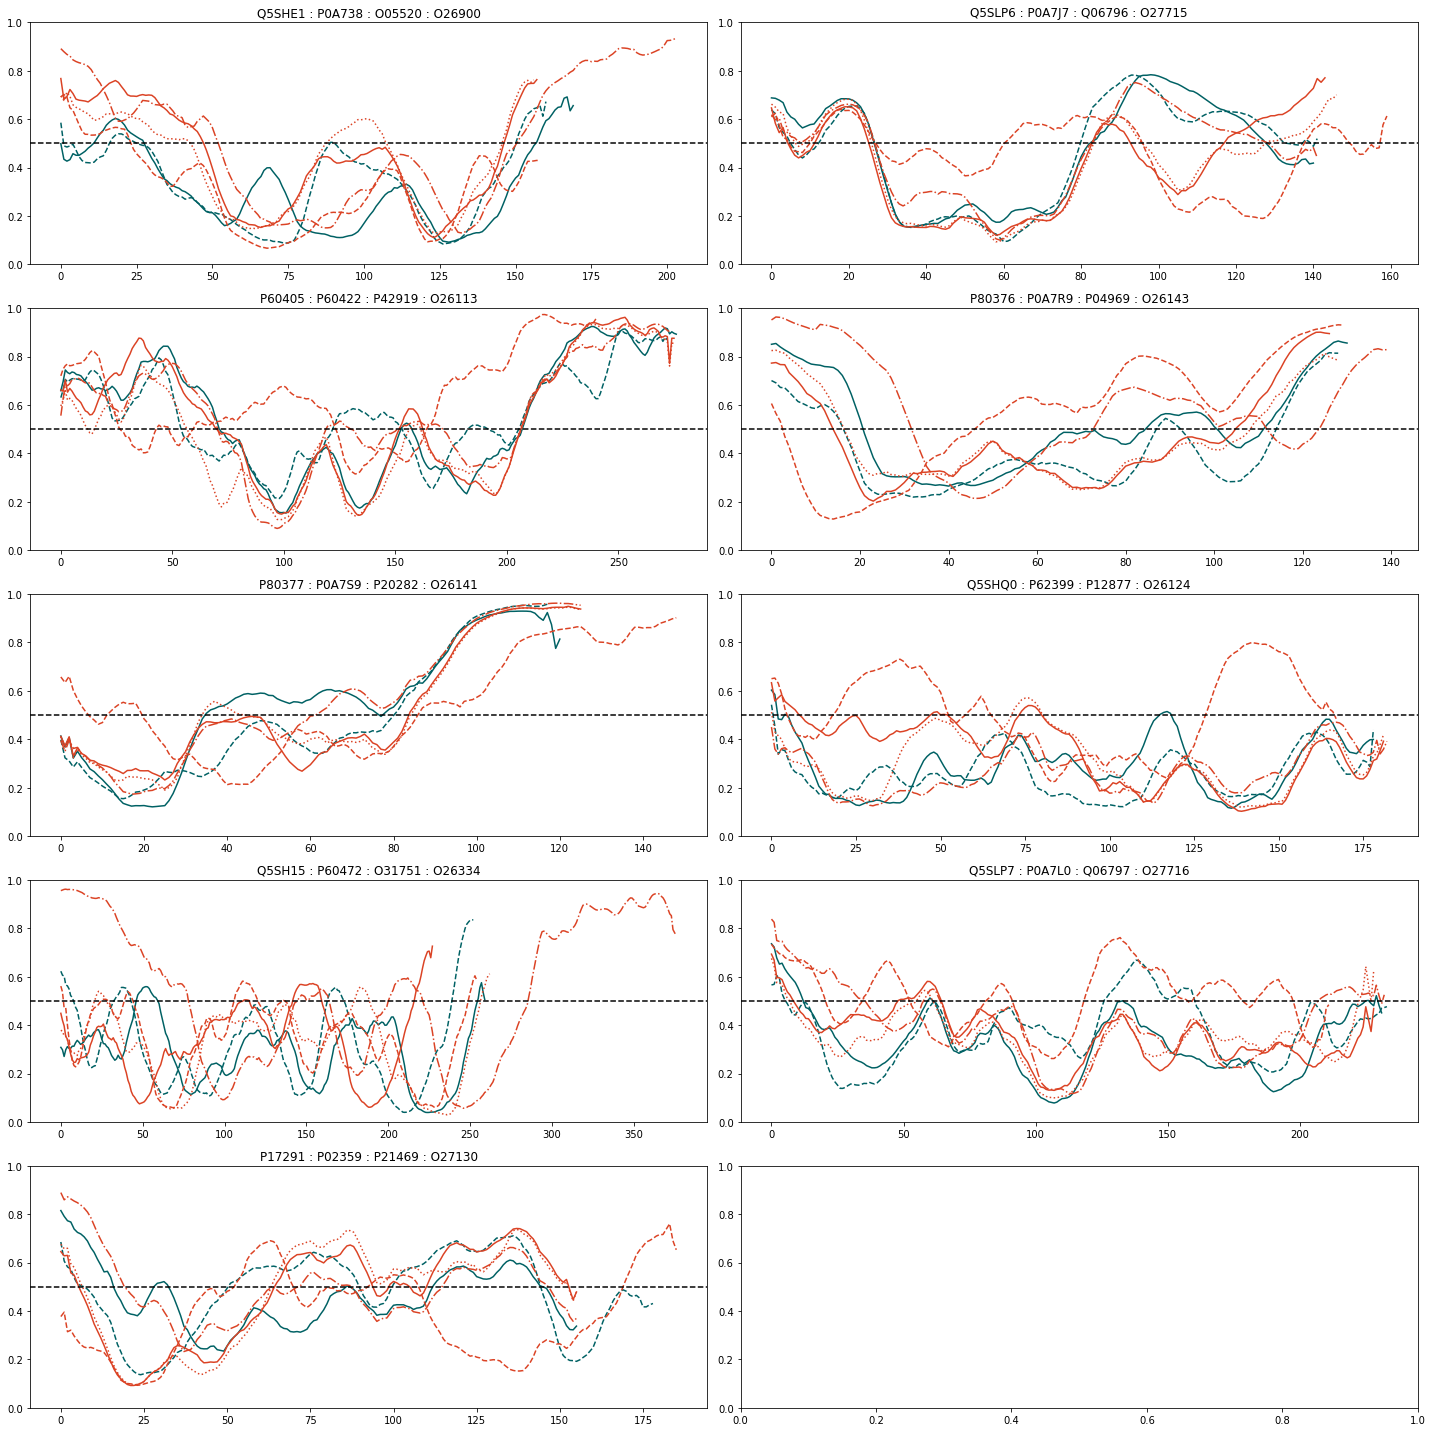

In [ ]:
pairs_long = orthologs_df.query("TT_disorder_binary_mean>=0.5 or TM_disorder_binary_mean>=0.5 or MH_disorder_binary_mean>=0.5 or MT_disorder_binary_mean>=0.5")

n_pairs = len(pairs_long)

conv = 1

fig, axs = plt.subplots(nrows=(n_pairs//2)+1, ncols=2, figsize=(20,20))
for i, ax in enumerate(fig.axes):
  if i < n_pairs:
    title = pairs_long.TT_ID.iloc[i] + ' : ' + pairs_long.EC_ID.iloc[i] + ' : '\
          + pairs_long.BS_ID.iloc[i] + ' : ' + pairs_long.MT_ID.iloc[i]
    ax.set_title(title)
    ax.set_ylim(0, 1)
    ax.plot(np.convolve(pairs_long.BS_disorder_combined.iloc[i], np.ones(conv)/conv), c=colors[0], linestyle=linestyles[0])
    ax.plot(np.convolve(pairs_long.EC_disorder_combined.iloc[i], np.ones(conv)/conv), c=colors[1], linestyle=linestyles[1])
    ax.plot(np.convolve(pairs_long.MH_disorder_combined.iloc[i], np.ones(conv)/conv), c=colors[2], linestyle=linestyles[2])
    ax.plot(np.convolve(pairs_long.MT_disorder_combined.iloc[i], np.ones(conv)/conv), c=colors[3], linestyle=linestyles[3])
    ax.plot(np.convolve(pairs_long.TM_disorder_combined.iloc[i], np.ones(conv)/conv), c=colors[4], linestyle=linestyles[4])
    ax.plot(np.convolve(pairs_long.TT_disorder_combined.iloc[i], np.ones(conv)/conv), c=colors[5], linestyle=linestyles[5])
    ax.axhline(0.5, ls='--', c='black')

plt.tight_layout()

In [ ]:
IDP_pairs['T_disorder_mean'] = IDP_pairs[['MH_disorder_mean', 'MT_disorder_mean', 'TM_disorder_mean', 'TT_disorder_mean']].mean(axis=1)
IDP_pairs['M_disorder_mean'] = IDP_pairs[['BS_disorder_mean', 'EC_disorder_mean']].mean(axis=1)

In [ ]:
IDP_pairs['disorder_mean_diff'] = IDP_pairs.T_disorder_mean / IDP_pairs.M_disorder_mean

In [ ]:
IDP_pairs.sort_values('disorder_mean_diff', ascending=False).head(10)[['BS_disorder_mean', 'EC_disorder_mean', 'MH_disorder_mean', 'MT_disorder_mean', 'TM_disorder_mean', 'TT_disorder_mean']]

BS_disorder_mean  EC_disorder_mean  MH_disorder_mean  MT_disorder_mean  \
15          0.220412          0.228217          0.305444          0.277465   
33          0.231553          0.272612          0.343761          0.342725   
62          0.344430          0.235657          0.364799          0.331401   
84          0.289438          0.276365          0.391542          0.354392   
2           0.277802          0.235252          0.341648          0.279814   
47          0.286088          0.252262          0.343226          0.508177   
7           0.314358          0.328984          0.440095          0.310268   
25          0.299686          0.242522          0.322078          0.270110   
14          0.290833          0.313507          0.403736          0.351299   
61          0.130194          0.086043          0.114565          0.188328   

    TM_disorder_mean  TT_disorder_mean  
15          0.403321          0.402838  
33          0.453460          0.354964  
62          0.523840          0.357643  
84          0.350580          0.430660  
2           0.410110          0.346279  
47          0.268157          0.308121  
7           0.516506          0.425859  
25          0.455947          0.370640  
14          0.489558          0.306743  
61          0.131524          0.115285

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


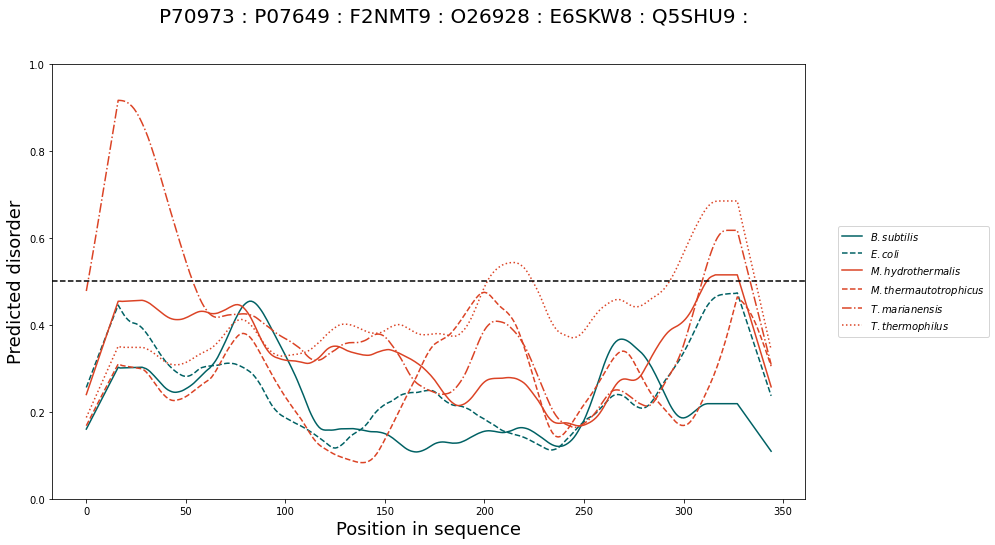

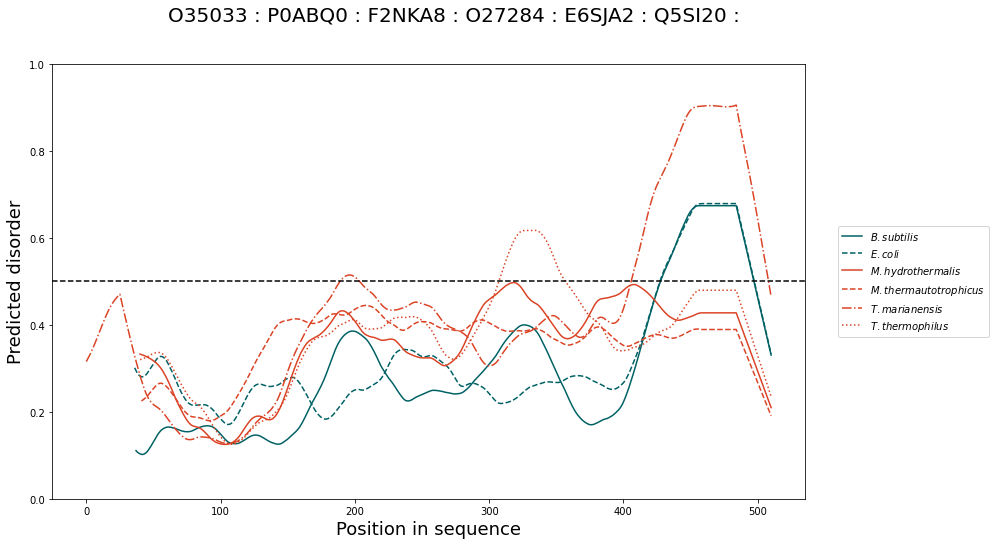

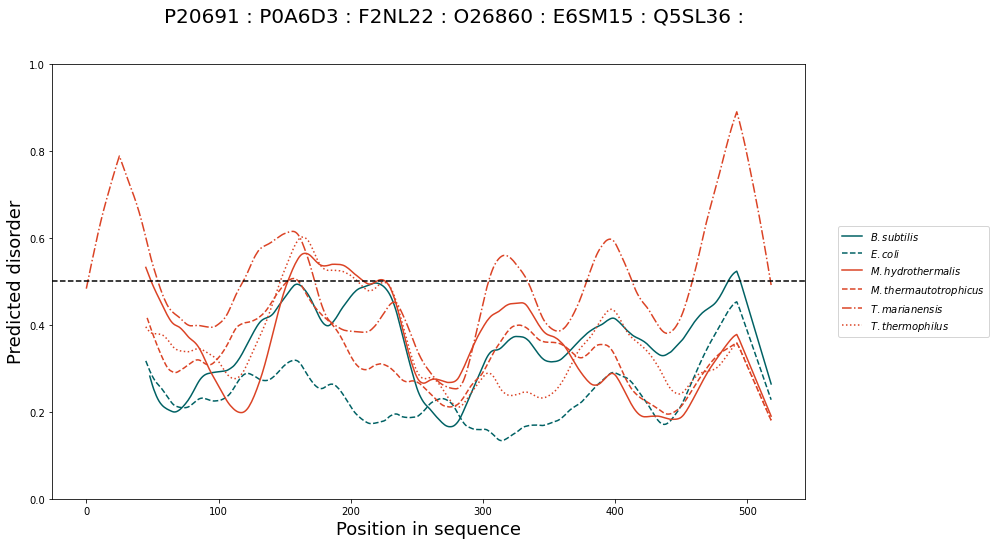

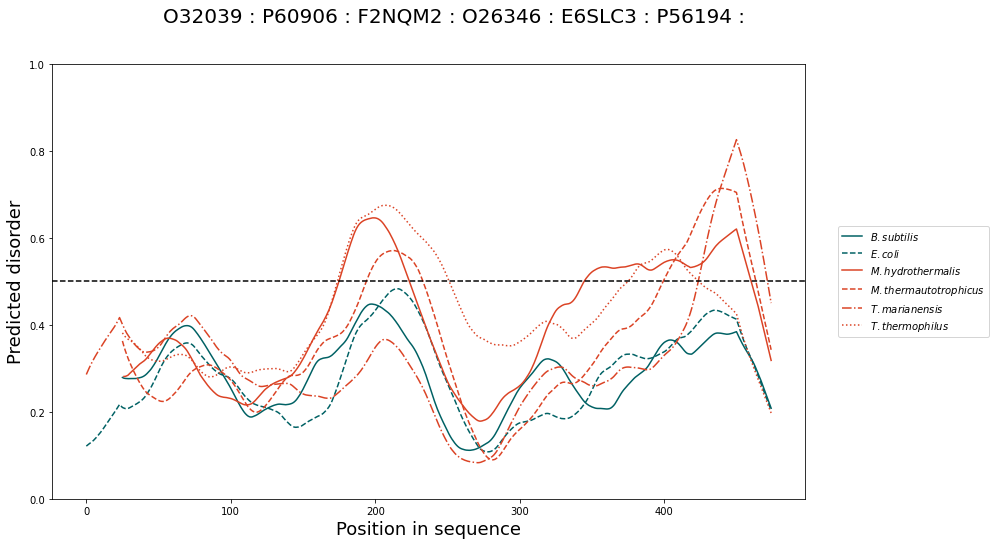

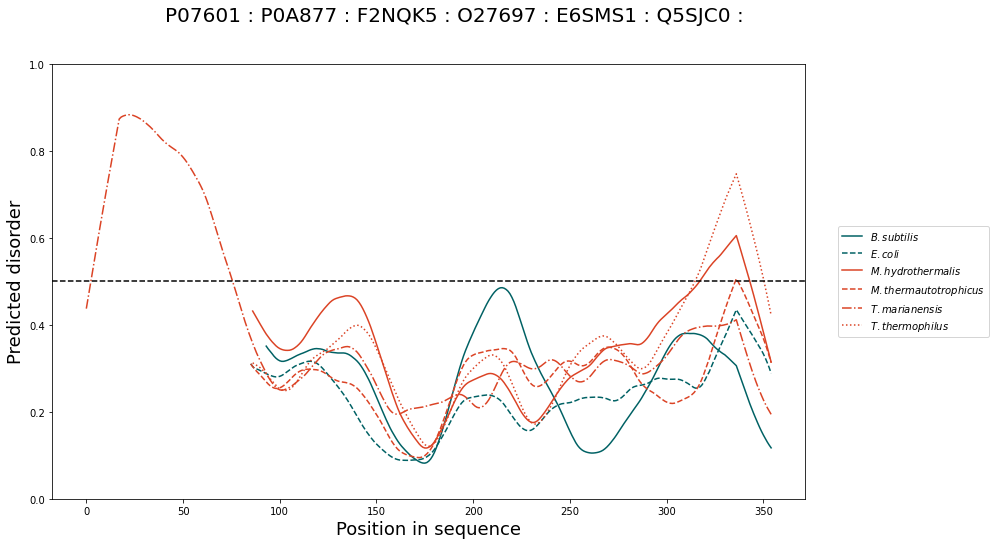

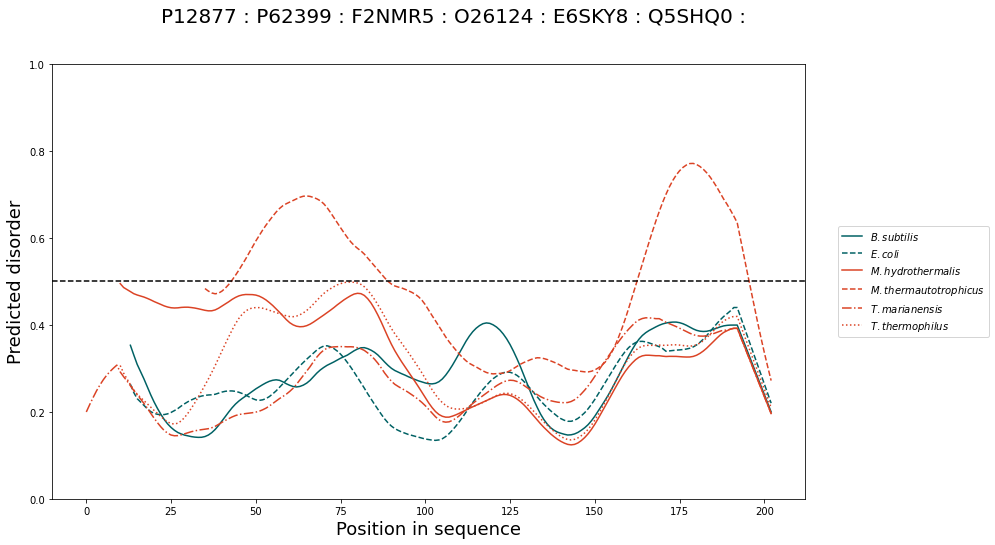

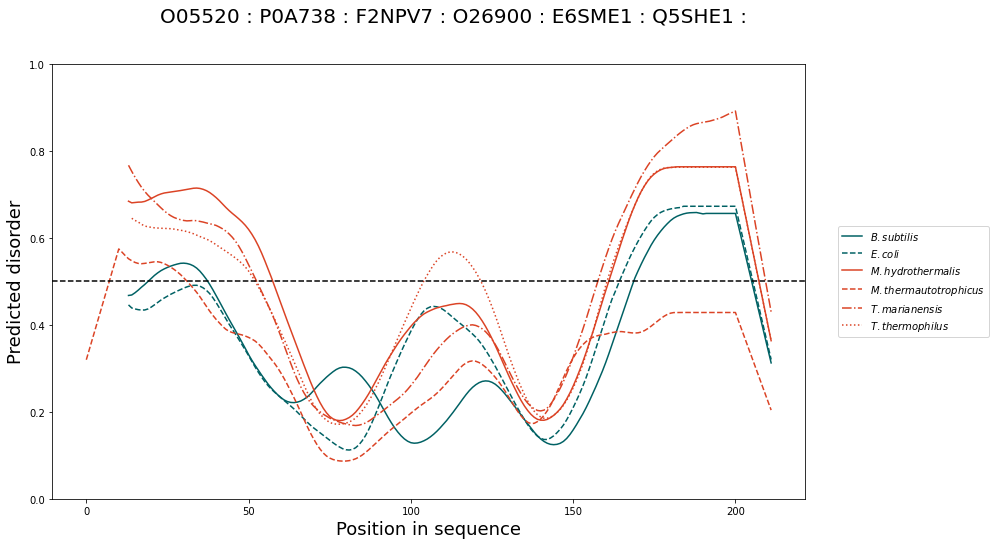

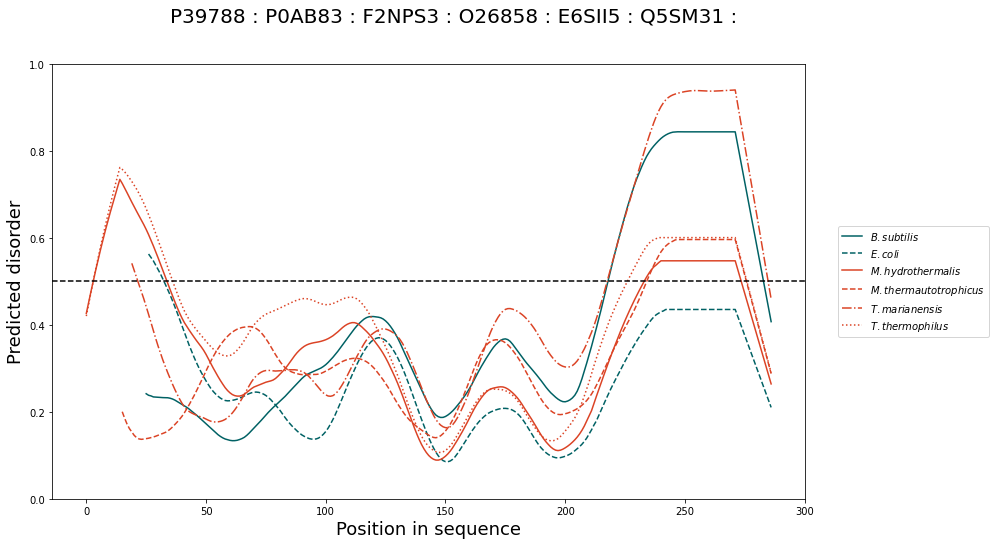

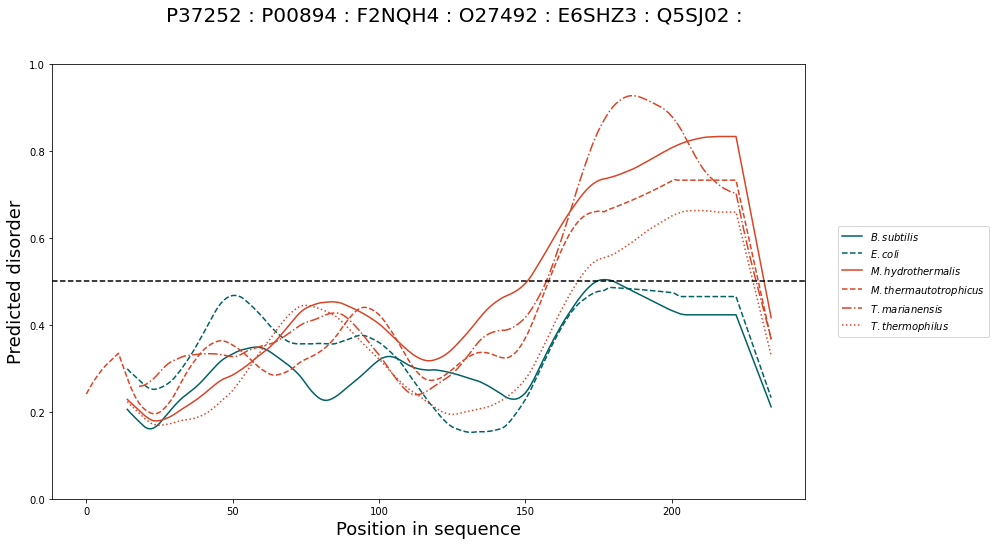

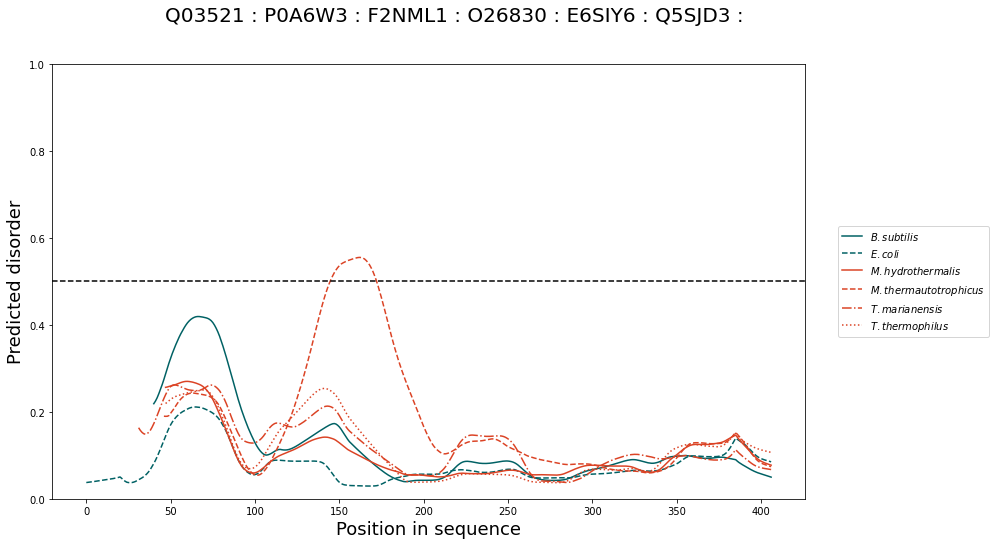

In [ ]:
for n in tqdm(IDP_pairs.sort_values('disorder_mean_diff', ascending=False).head(10)[['BS_ID', 'EC_ID', 'MH_ID', 'MT_ID', 'TM_ID', 'TT_ID']].values):
  names = [*n]
  
  fig_name = ''.join([n + '-' for n in names])[:-1] + '.svg'

  disorder_values = [IDP_pairs.query('BS_ID=="{}"'.format(names[0])).BS_disorder_combined.iloc[0],
                    IDP_pairs.query('EC_ID=="{}"'.format(names[1])).EC_disorder_combined.iloc[0],
                    IDP_pairs.query('MH_ID=="{}"'.format(names[2])).MH_disorder_combined.iloc[0],
                    IDP_pairs.query('MT_ID=="{}"'.format(names[3])).MT_disorder_combined.iloc[0],
                    IDP_pairs.query('TM_ID=="{}"'.format(names[4])).TM_disorder_combined.iloc[0],
                    IDP_pairs.query('TT_ID=="{}"'.format(names[5])).TT_disorder_combined.iloc[0]]
  seqs = [IDP_pairs.query('BS_ID=="{}"'.format(names[0])).BS_Sequence.iloc[0],
          IDP_pairs.query('EC_ID=="{}"'.format(names[1])).EC_Sequence.iloc[0],
          IDP_pairs.query('MH_ID=="{}"'.format(names[2])).MH_Sequence.iloc[0],
          IDP_pairs.query('MT_ID=="{}"'.format(names[3])).MT_Sequence.iloc[0],
          IDP_pairs.query('TM_ID=="{}"'.format(names[4])).TM_Sequence.iloc[0],
          IDP_pairs.query('TT_ID=="{}"'.format(names[5])).TT_Sequence.iloc[0]]

  plot_IDR_profile(disorder_values=disorder_values, seqs=seqs, labels=species_names_s, colors=colors, linestyles=linestyles, names=names,
                   mav=50, scale_mav=True, gap_ins_pen=-5.0, gap_ext_pen=-0.5, savefig=True)

100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


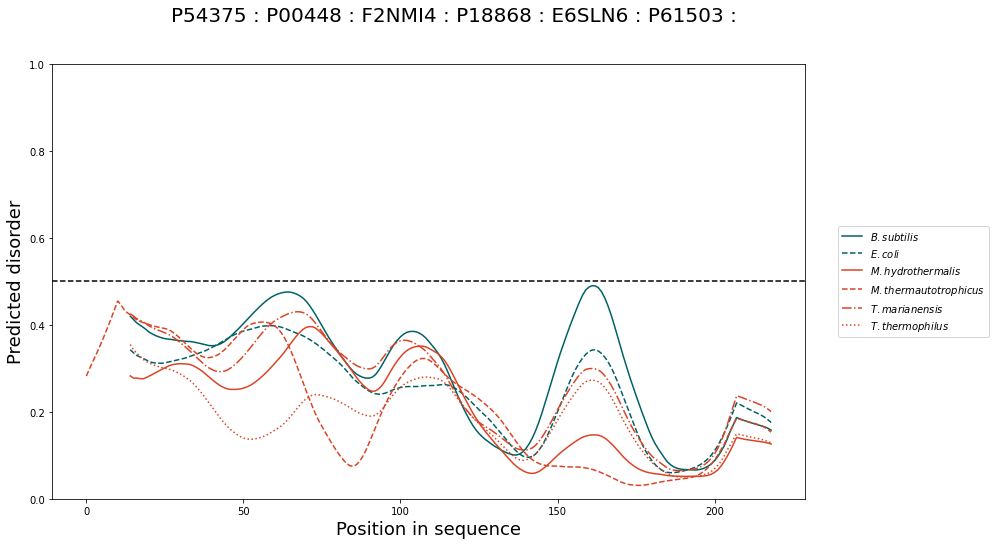

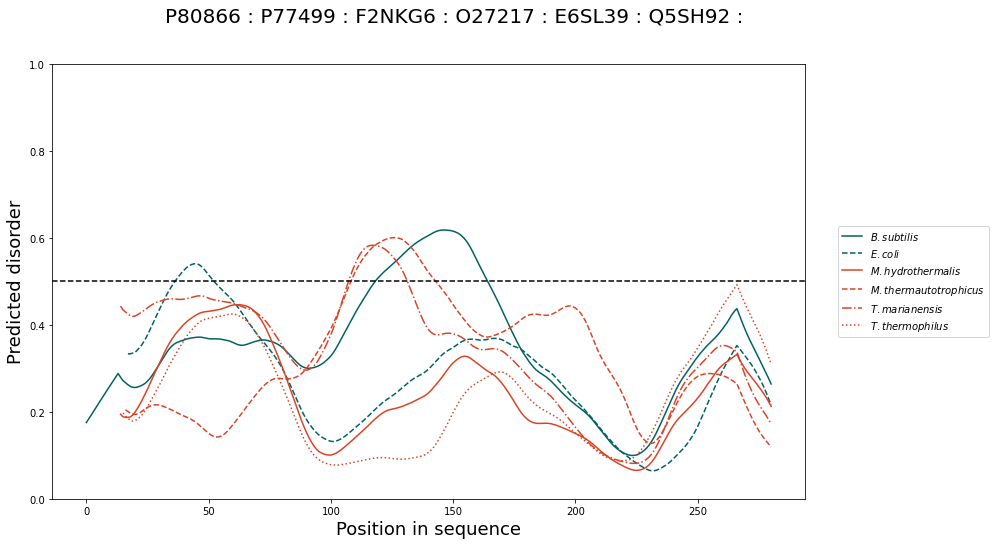

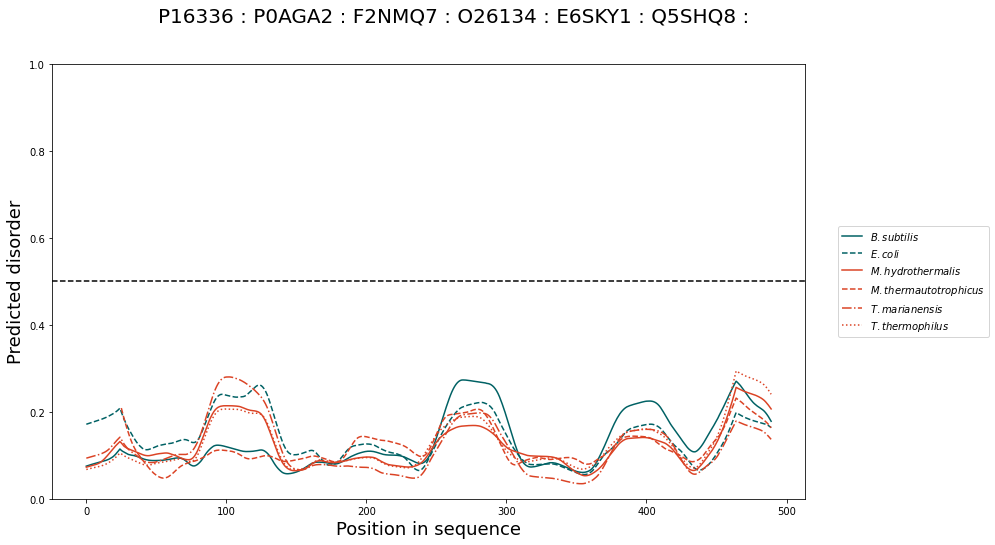

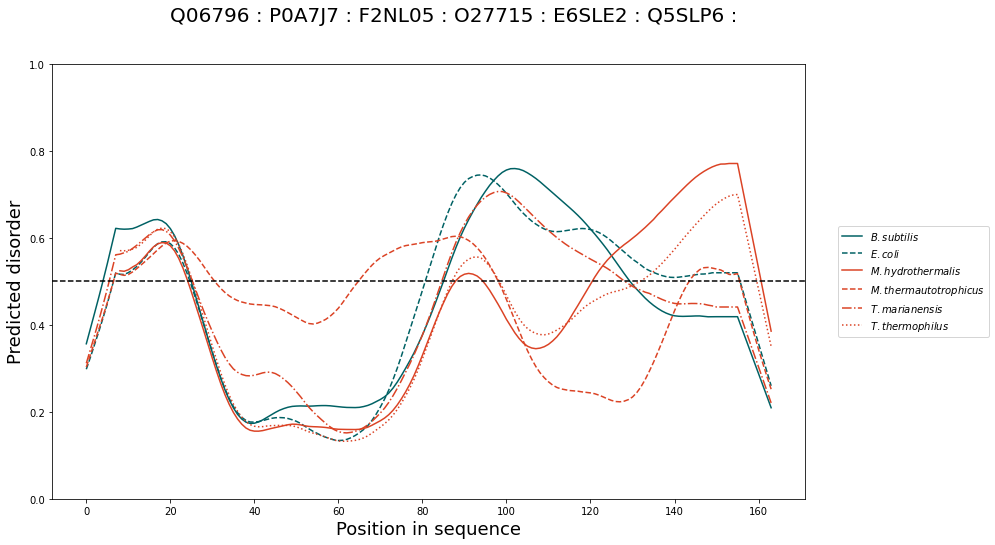

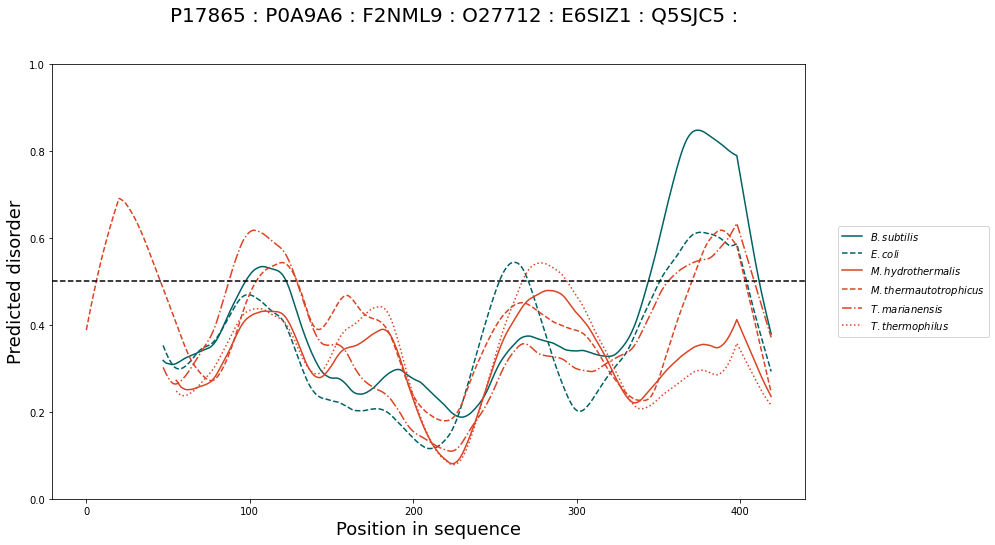

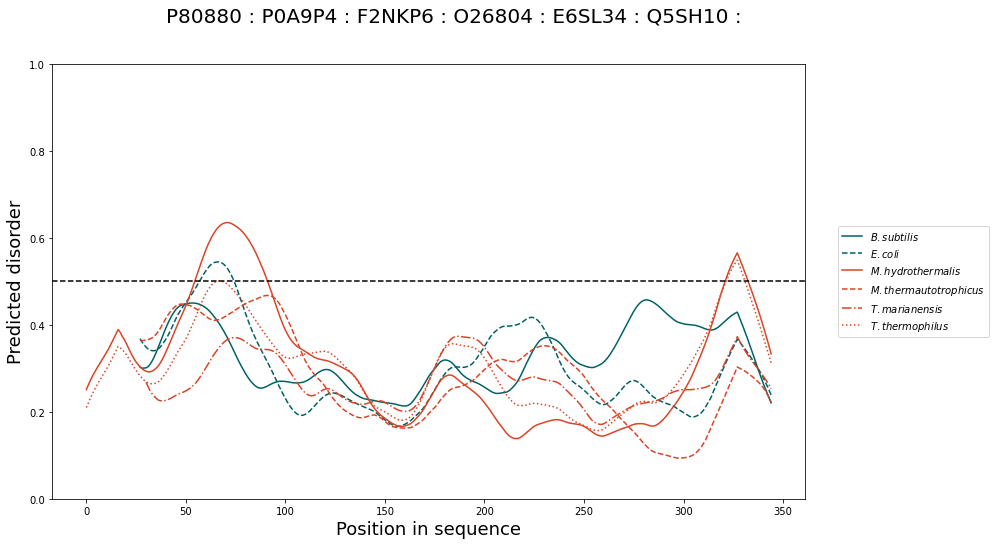

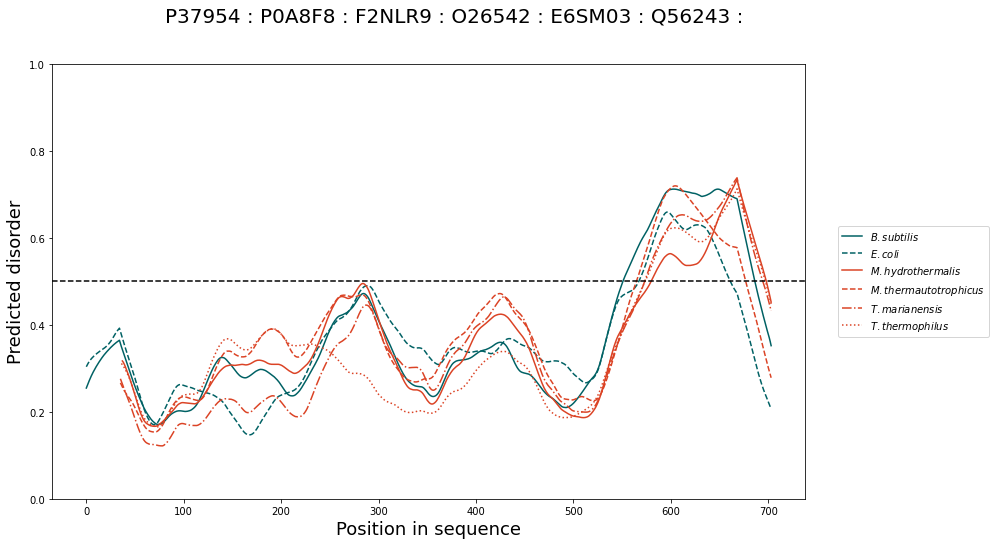

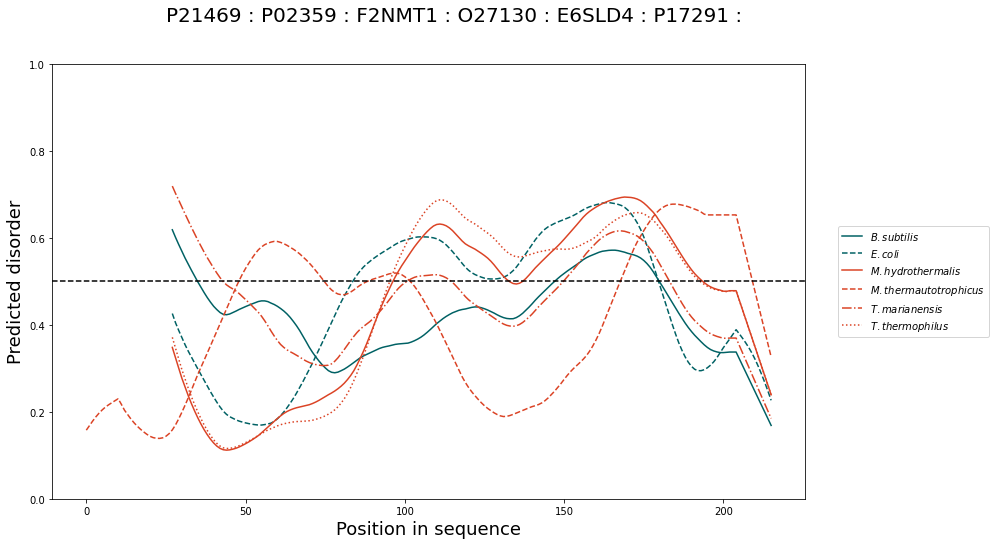

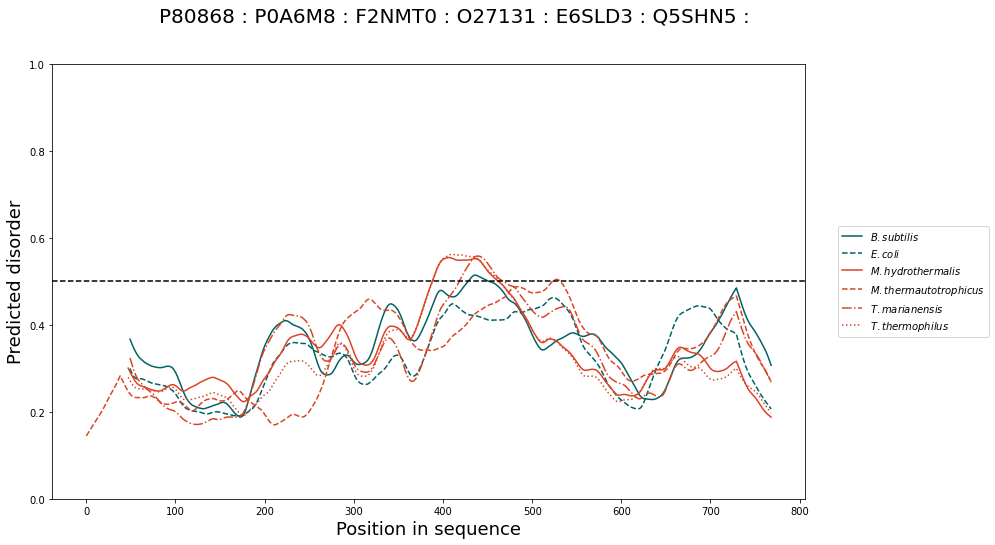

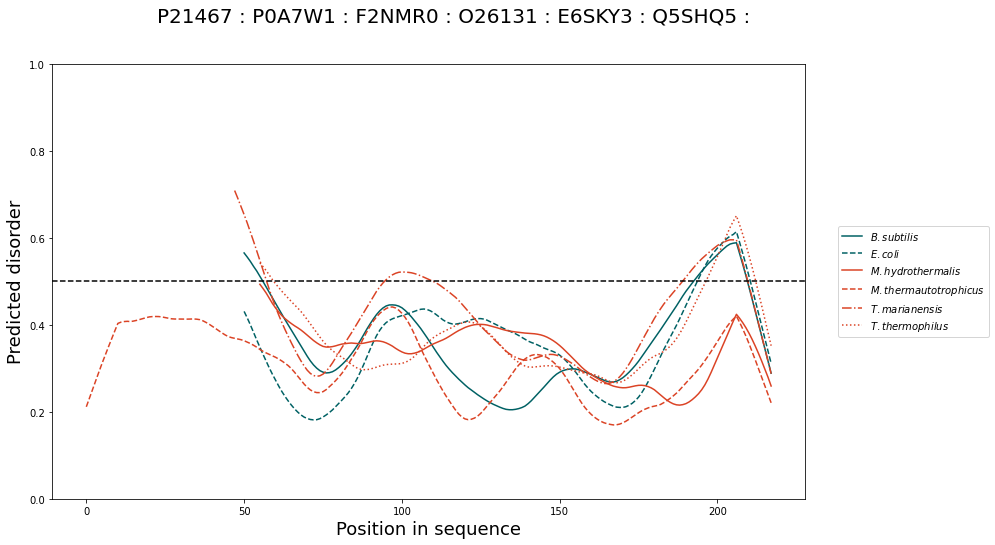

In [ ]:
for n in tqdm(IDP_pairs.sort_values('disorder_mean_diff', ascending=True).head(10)[['BS_ID', 'EC_ID', 'MH_ID', 'MT_ID', 'TM_ID', 'TT_ID']].values):
  names = [*n]
  
  fig_name = ''.join([n + '-' for n in names])[:-1] + '.svg'

  disorder_values = [IDP_pairs.query('BS_ID=="{}"'.format(names[0])).BS_disorder_combined.iloc[0],
                    IDP_pairs.query('EC_ID=="{}"'.format(names[1])).EC_disorder_combined.iloc[0],
                    IDP_pairs.query('MH_ID=="{}"'.format(names[2])).MH_disorder_combined.iloc[0],
                    IDP_pairs.query('MT_ID=="{}"'.format(names[3])).MT_disorder_combined.iloc[0],
                    IDP_pairs.query('TM_ID=="{}"'.format(names[4])).TM_disorder_combined.iloc[0],
                    IDP_pairs.query('TT_ID=="{}"'.format(names[5])).TT_disorder_combined.iloc[0]]
  seqs = [IDP_pairs.query('BS_ID=="{}"'.format(names[0])).BS_Sequence.iloc[0],
          IDP_pairs.query('EC_ID=="{}"'.format(names[1])).EC_Sequence.iloc[0],
          IDP_pairs.query('MH_ID=="{}"'.format(names[2])).MH_Sequence.iloc[0],
          IDP_pairs.query('MT_ID=="{}"'.format(names[3])).MT_Sequence.iloc[0],
          IDP_pairs.query('TM_ID=="{}"'.format(names[4])).TM_Sequence.iloc[0],
          IDP_pairs.query('TT_ID=="{}"'.format(names[5])).TT_Sequence.iloc[0]]

  plot_IDR_profile(disorder_values=disorder_values, seqs=seqs, labels=species_names_s, colors=colors, linestyles=linestyles, names=names,
                   mav=50, scale_mav=True, gap_ins_pen=-5.0, gap_ext_pen=-0.5, savefig=True)

## Visualisation and statistical analysis



### Whole proteomes

MannwhitneyuResult(statistic=6702160.0, pvalue=1.7114621078226253e-138)
MannwhitneyuResult(statistic=6030197.0, pvalue=2.6955939395947783e-75)
MannwhitneyuResult(statistic=3836010.5, pvalue=2.6780356576906144e-34)
MannwhitneyuResult(statistic=8420357.0, pvalue=7.240380653788498e-15)
MannwhitneyuResult(statistic=5169481.0, pvalue=2.1140022604516405e-39)
MannwhitneyuResult(statistic=5616821.0, pvalue=2.7561883183637314e-09)


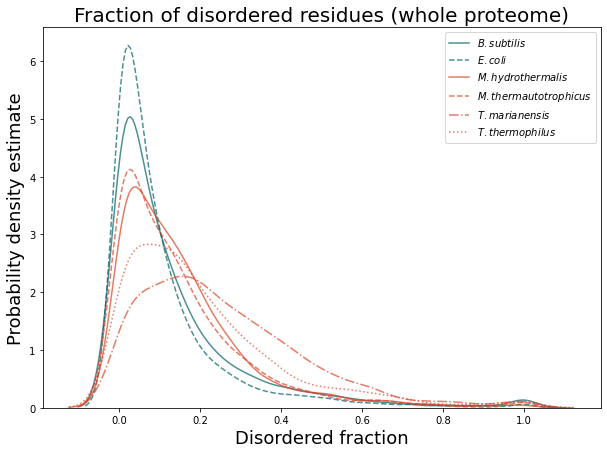

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'BS':BS_proteome.disorder_binary_mean,
                   'EC':EC_proteome.disorder_binary_mean,
                   'MH':MH_proteome.disorder_binary_mean,
                   'MT':MT_proteome.disorder_binary_mean,
                   'TM':TM_proteome.disorder_binary_mean,
                   'TT':TT_proteome.disorder_binary_mean})

sns.kdeplot(df.BS, color=colors[0], linestyle=linestyles[0], alpha=0.7, label='$\\it{}$'.format(species_names_s[0]), ax=ax)
sns.kdeplot(df.EC, color=colors[1], linestyle=linestyles[1], alpha=0.7, label='$\\it{}$'.format(species_names_s[1]), ax=ax)
sns.kdeplot(df.MH, color=colors[2], linestyle=linestyles[2], alpha=0.7, label='$\\it{}$'.format(species_names_s[2]), ax=ax)
sns.kdeplot(df.MT, color=colors[3], linestyle=linestyles[3], alpha=0.7, label='$\\it{}$'.format(species_names_s[3]), ax=ax)
sns.kdeplot(df.TM, color=colors[4], linestyle=linestyles[4], alpha=0.7, label='$\\it{}$'.format(species_names_s[4]), ax=ax)
sns.kdeplot(df.TT, color=colors[5], linestyle=linestyles[5], alpha=0.7, label='$\\it{}$'.format(species_names_s[5]), ax=ax)
ax.set_title('Fraction of disordered residues (whole proteome)', fontsize=20)
ax.set_ylabel('Probability density estimate', fontsize=18)
ax.set_xlabel('Disordered fraction', fontsize=18)
ax.legend()

print(mannwhitneyu(df.TT.dropna(), df.EC.dropna()))
print(mannwhitneyu(df.TT.dropna(), df.BS.dropna()))
print(mannwhitneyu(df.TT.dropna(), df.MT.dropna()))
print(mannwhitneyu(df.EC.dropna(), df.BS.dropna()))
print(mannwhitneyu(df.EC.dropna(), df.MT.dropna()))
print(mannwhitneyu(df.BS.dropna(), df.MT.dropna()))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(ttest_ind(df.TT, df.EC, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig('Fraction of disordered residues (whole proteome).svg')

Ttest_indResult(statistic=22.664176266774415, pvalue=1.4008412488266332e-109)
Ttest_indResult(statistic=15.621829585835187, pvalue=4.971604414021539e-54)
Ttest_indResult(statistic=9.77394096968593, pvalue=2.287063808552968e-22)
Ttest_indResult(statistic=-7.038232254038612, pvalue=2.0956772244576618e-12)
Ttest_indResult(statistic=-13.396160311908238, pvalue=1.9178601797510794e-40)
Ttest_indResult(statistic=-6.288422675040285, pvalue=3.396428218391519e-10)


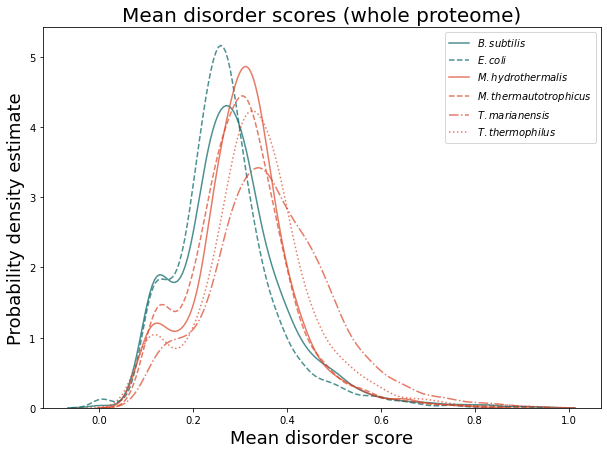

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'BS':BS_proteome.disorder_mean,
                   'EC':EC_proteome.disorder_mean,
                   'MH':MH_proteome.disorder_mean,
                   'MT':MT_proteome.disorder_mean,
                   'TM':TM_proteome.disorder_mean,
                   'TT':TT_proteome.disorder_mean})

sns.kdeplot(df.BS, color=colors[0], linestyle=linestyles[0], alpha=0.7, label='$\\it{}$'.format(species_names_s[0]), ax=ax)
sns.kdeplot(df.EC, color=colors[1], linestyle=linestyles[1], alpha=0.7, label='$\\it{}$'.format(species_names_s[1]), ax=ax)
sns.kdeplot(df.MH, color=colors[2], linestyle=linestyles[2], alpha=0.7, label='$\\it{}$'.format(species_names_s[2]), ax=ax)
sns.kdeplot(df.MT, color=colors[3], linestyle=linestyles[3], alpha=0.7, label='$\\it{}$'.format(species_names_s[3]), ax=ax)
sns.kdeplot(df.TM, color=colors[4], linestyle=linestyles[4], alpha=0.7, label='$\\it{}$'.format(species_names_s[4]), ax=ax)
sns.kdeplot(df.TT, color=colors[5], linestyle=linestyles[5], alpha=0.7, label='$\\it{}$'.format(species_names_s[5]), ax=ax)
ax.set_title('Mean disorder scores (whole proteome)', fontsize=20)
ax.set_ylabel('Probability density estimate', fontsize=18)
ax.set_xlabel('Mean disorder score', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
print(ttest_ind(df.TT, df.EC, nan_policy='omit'))
print(ttest_ind(df.TT, df.BS, nan_policy='omit'))
print(ttest_ind(df.TT, df.MT, nan_policy='omit'))
print(ttest_ind(df.EC, df.BS, nan_policy='omit'))
print(ttest_ind(df.EC, df.MT, nan_policy='omit'))
print(ttest_ind(df.BS, df.MT, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig('Mean disorder scores (whole proteome).svg')

### Orthologs

WilcoxonResult(statistic=654.0, pvalue=1.621105177110813e-07)
WilcoxonResult(statistic=1049.0, pvalue=0.0002512161202188521)
WilcoxonResult(statistic=1514.0, pvalue=0.09046387644892571)
WilcoxonResult(statistic=1513.0, pvalue=0.06408604800272637)
WilcoxonResult(statistic=1038.0, pvalue=0.00012919330584825375)
WilcoxonResult(statistic=1529.0, pvalue=0.07426017019646415)


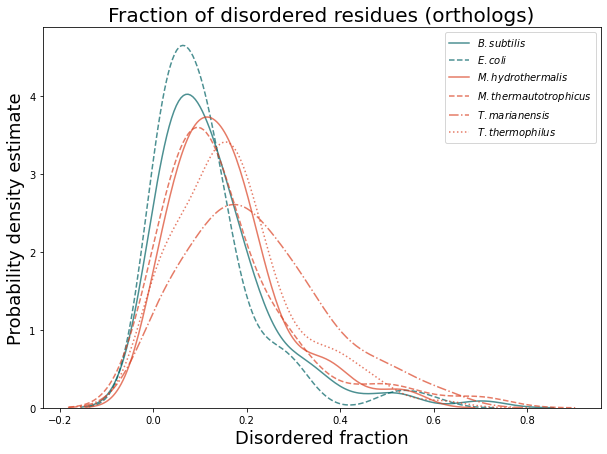

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'BS':IDP_pairs.BS_disorder_binary_mean,
                   'EC':IDP_pairs.EC_disorder_binary_mean,
                   'MH':IDP_pairs.MH_disorder_binary_mean,
                   'MT':IDP_pairs.MT_disorder_binary_mean,
                   'TM':IDP_pairs.TM_disorder_binary_mean,
                   'TT':IDP_pairs.TT_disorder_binary_mean,
                   'dis_len':(IDP_pairs.BS_longest_IDR + IDP_pairs.EC_longest_IDR +\
                              IDP_pairs.MH_longest_IDR + IDP_pairs.MT_longest_IDR +\
                              IDP_pairs.TM_longest_IDR + IDP_pairs.TT_longest_IDR) / 6})

sns.kdeplot(df.BS, color=colors[0], linestyle=linestyles[0], alpha=0.7, label='$\\it{}$'.format(species_names_s[0]), ax=ax)
sns.kdeplot(df.EC, color=colors[1], linestyle=linestyles[1], alpha=0.7, label='$\\it{}$'.format(species_names_s[1]), ax=ax)
sns.kdeplot(df.MH, color=colors[2], linestyle=linestyles[2], alpha=0.7, label='$\\it{}$'.format(species_names_s[2]), ax=ax)
sns.kdeplot(df.MT, color=colors[3], linestyle=linestyles[3], alpha=0.7, label='$\\it{}$'.format(species_names_s[3]), ax=ax)
sns.kdeplot(df.TM, color=colors[4], linestyle=linestyles[4], alpha=0.7, label='$\\it{}$'.format(species_names_s[4]), ax=ax)
sns.kdeplot(df.TT, color=colors[5], linestyle=linestyles[5], alpha=0.7, label='$\\it{}$'.format(species_names_s[5]), ax=ax)
ax.set_title('Fraction of disordered residues (orthologs)', fontsize=20)
ax.set_ylabel('Probability density estimate', fontsize=18)
ax.set_xlabel('Disordered fraction', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
print(wilcoxon(df.TT.dropna(), df.EC.dropna()))
print(wilcoxon(df.TT.dropna(), df.BS.dropna()))
print(wilcoxon(df.TT.dropna(), df.MT.dropna()))
print(wilcoxon(df.EC.dropna(), df.BS.dropna()))
print(wilcoxon(df.EC.dropna(), df.MT.dropna()))
print(wilcoxon(df.BS.dropna(), df.MT.dropna()))
# print(ttest_ind(df.TT, df.EC, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig('Fraction of disordered residues (orthologs).svg')

Ttest_relResult(statistic=7.0262255325130685, pvalue=4.2929730037559927e-10)
Ttest_relResult(statistic=3.5326235785579465, pvalue=0.0006578039409058792)
Ttest_relResult(statistic=0.08639690117194689, pvalue=0.9313471898635698)
Ttest_relResult(statistic=-3.830217038381809, pvalue=0.00023949139092567962)
Ttest_relResult(statistic=-6.672442559477807, pvalue=2.1522325528226675e-09)
Ttest_relResult(statistic=-3.3851613339883397, pvalue=0.0010645222339872623)


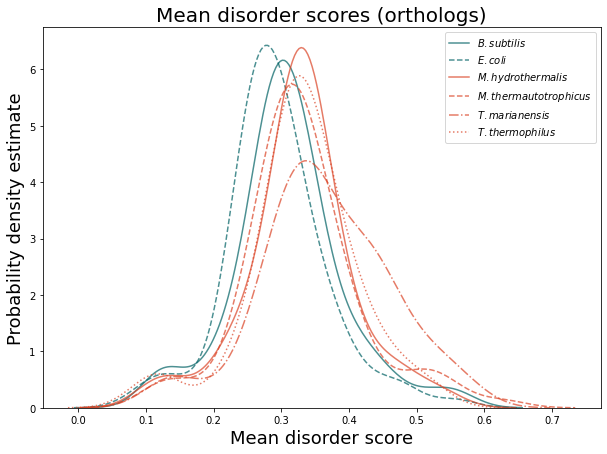

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'BS':IDP_pairs.BS_disorder_mean,
                   'EC':IDP_pairs.EC_disorder_mean,
                   'MH':IDP_pairs.MH_disorder_mean,
                   'MT':IDP_pairs.MT_disorder_mean,
                   'TM':IDP_pairs.TM_disorder_mean,
                   'TT':IDP_pairs.TT_disorder_mean})

sns.kdeplot(df.BS, color=colors[0], linestyle=linestyles[0], alpha=0.7, label='$\\it{}$'.format(species_names_s[0]), ax=ax)
sns.kdeplot(df.EC, color=colors[1], linestyle=linestyles[1], alpha=0.7, label='$\\it{}$'.format(species_names_s[1]), ax=ax)
sns.kdeplot(df.MH, color=colors[2], linestyle=linestyles[2], alpha=0.7, label='$\\it{}$'.format(species_names_s[2]), ax=ax)
sns.kdeplot(df.MT, color=colors[3], linestyle=linestyles[3], alpha=0.7, label='$\\it{}$'.format(species_names_s[3]), ax=ax)
sns.kdeplot(df.TM, color=colors[4], linestyle=linestyles[4], alpha=0.7, label='$\\it{}$'.format(species_names_s[4]), ax=ax)
sns.kdeplot(df.TT, color=colors[5], linestyle=linestyles[5], alpha=0.7, label='$\\it{}$'.format(species_names_s[5]), ax=ax)
ax.set_title('Mean disorder scores (orthologs)', fontsize=20)
ax.set_ylabel('Probability density estimate', fontsize=18)
ax.set_xlabel('Mean disorder score', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(ttest_ind(df.TT, df.EC, nan_policy='omit'))
print(ttest_rel(df.TT, df.EC, nan_policy='omit'))
print(ttest_rel(df.TT, df.BS, nan_policy='omit'))
print(ttest_rel(df.TT, df.MT, nan_policy='omit'))
print(ttest_rel(df.EC, df.BS, nan_policy='omit'))
print(ttest_rel(df.EC, df.MT, nan_policy='omit'))
print(ttest_rel(df.BS, df.MT, nan_policy='omit'))

fig.show()
fig.savefig('Mean disorder scores (orthologs).svg')

### Exclusive to each proteome

In [ ]:
BS_only = BS_proteome[~BS_proteome.ID.isin(IDP_pairs.BS_ID)]
EC_only = EC_proteome[~EC_proteome.ID.isin(IDP_pairs.EC_ID)]
MH_only = MH_proteome[~MH_proteome.ID.isin(IDP_pairs.MH_ID)]
MT_only = MT_proteome[~MT_proteome.ID.isin(IDP_pairs.MT_ID)]
TM_only = TM_proteome[~TM_proteome.ID.isin(IDP_pairs.TM_ID)]
TT_only = TT_proteome[~TT_proteome.ID.isin(IDP_pairs.TT_ID)]

MannwhitneyuResult(statistic=6305926.0, pvalue=2.2524115111438326e-134)
MannwhitneyuResult(statistic=5672121.5, pvalue=2.2064416897084364e-73)
MannwhitneyuResult(statistic=3575743.0, pvalue=6.8330438303146865e-34)
MannwhitneyuResult(statistic=8081997.5, pvalue=1.962709643734138e-14)
MannwhitneyuResult(statistic=4920724.5, pvalue=1.4903675557543613e-37)
MannwhitneyuResult(statistic=5337976.0, pvalue=8.41455044862872e-09)


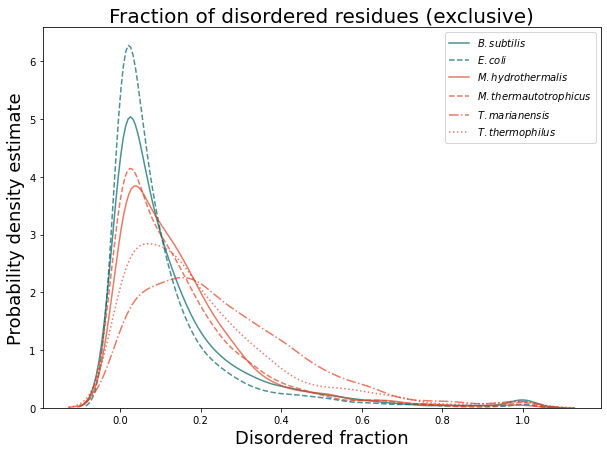

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'BS':BS_only.disorder_binary_mean,
                   'EC':EC_only.disorder_binary_mean,
                   'MH':MH_only.disorder_binary_mean,
                   'MT':MT_only.disorder_binary_mean,
                   'TM':TM_only.disorder_binary_mean,
                   'TT':TT_only.disorder_binary_mean})

sns.kdeplot(df.BS, color=colors[0], linestyle=linestyles[0], alpha=0.7, label='$\\it{}$'.format(species_names_s[0]), ax=ax)
sns.kdeplot(df.EC, color=colors[1], linestyle=linestyles[1], alpha=0.7, label='$\\it{}$'.format(species_names_s[1]), ax=ax)
sns.kdeplot(df.MH, color=colors[2], linestyle=linestyles[2], alpha=0.7, label='$\\it{}$'.format(species_names_s[2]), ax=ax)
sns.kdeplot(df.MT, color=colors[3], linestyle=linestyles[3], alpha=0.7, label='$\\it{}$'.format(species_names_s[3]), ax=ax)
sns.kdeplot(df.TM, color=colors[4], linestyle=linestyles[4], alpha=0.7, label='$\\it{}$'.format(species_names_s[4]), ax=ax)
sns.kdeplot(df.TT, color=colors[5], linestyle=linestyles[5], alpha=0.7, label='$\\it{}$'.format(species_names_s[5]), ax=ax)
ax.set_title('Fraction of disordered residues (exclusive)', fontsize=20)
ax.set_ylabel('Probability density estimate', fontsize=18)
ax.set_xlabel('Disordered fraction', fontsize=18)
ax.legend()

print(mannwhitneyu(df.TT.dropna(), df.EC.dropna()))
print(mannwhitneyu(df.TT.dropna(), df.BS.dropna()))
print(mannwhitneyu(df.TT.dropna(), df.MT.dropna()))
print(mannwhitneyu(df.EC.dropna(), df.BS.dropna()))
print(mannwhitneyu(df.EC.dropna(), df.MT.dropna()))
print(mannwhitneyu(df.BS.dropna(), df.MT.dropna()))

fig.show()
fig.savefig('Fraction of disordered residues (exclusive).svg')

Ttest_indResult(statistic=22.344485756787478, pvalue=1.4364991843309638e-106)
Ttest_indResult(statistic=15.44938974222885, pvalue=7.0581156924923765e-53)
Ttest_indResult(statistic=9.828173237829782, pvalue=1.3725890524971973e-22)
Ttest_indResult(statistic=-6.921536715422248, pvalue=4.793563975584194e-12)
Ttest_indResult(statistic=-13.010434477082361, pvalue=2.9212571674717873e-38)
Ttest_indResult(statistic=-6.04402324089083, pvalue=1.5808988764280459e-09)


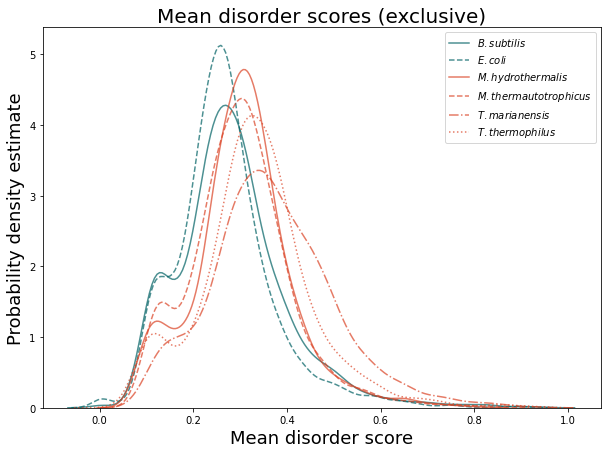

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'BS':BS_only.disorder_mean,
                   'EC':EC_only.disorder_mean,
                   'MH':MH_only.disorder_mean,
                   'MT':MT_only.disorder_mean,
                   'TM':TM_only.disorder_mean,
                   'TT':TT_only.disorder_mean})

sns.kdeplot(df.BS, color=colors[0], linestyle=linestyles[0], alpha=0.7, label='$\\it{}$'.format(species_names_s[0]), ax=ax)
sns.kdeplot(df.EC, color=colors[1], linestyle=linestyles[1], alpha=0.7, label='$\\it{}$'.format(species_names_s[1]), ax=ax)
sns.kdeplot(df.MH, color=colors[2], linestyle=linestyles[2], alpha=0.7, label='$\\it{}$'.format(species_names_s[2]), ax=ax)
sns.kdeplot(df.MT, color=colors[3], linestyle=linestyles[3], alpha=0.7, label='$\\it{}$'.format(species_names_s[3]), ax=ax)
sns.kdeplot(df.TM, color=colors[4], linestyle=linestyles[4], alpha=0.7, label='$\\it{}$'.format(species_names_s[4]), ax=ax)
sns.kdeplot(df.TT, color=colors[5], linestyle=linestyles[5], alpha=0.7, label='$\\it{}$'.format(species_names_s[5]), ax=ax)
ax.set_title('Mean disorder scores (exclusive)', fontsize=20)
ax.set_ylabel('Probability density estimate', fontsize=18)
ax.set_xlabel('Mean disorder score', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
print(ttest_ind(df.TT, df.EC, nan_policy='omit'))
print(ttest_ind(df.TT, df.BS, nan_policy='omit'))
print(ttest_ind(df.TT, df.MT, nan_policy='omit'))
print(ttest_ind(df.EC, df.BS, nan_policy='omit'))
print(ttest_ind(df.EC, df.MT, nan_policy='omit'))
print(ttest_ind(df.BS, df.MT, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig('Mean disorder scores (exclusive).svg')

### Exclusive to each proteome - most disordered

In [ ]:
n_top = 10

TT_only_top = TT_only.query("longest_IDR>=50").sort_values('disorder_mean', ascending=False).iloc[:n_top]
EC_only_top = EC_only.query("longest_IDR>=50").sort_values('disorder_mean', ascending=False).iloc[:n_top]

In [ ]:
TT_only_top

ID                                           Sequence  Length  \
1723  Q5SKG1  MVRYEPALPLPSYTVRLAPVPVEAVREEAKPQAPIPEARPAEASRP...     383   
187   Q5SKU1  MPKMKTHKGAKKRVKITASGKVVAMKTGKRHLNWQKSGKEIRQKGR...      65   
1091  Q5SII7  MKNAWQRLKEAWANLPRSTKLLLAALLLVGNVALWYVGLYLPAQVA...     292   
505   Q5SJ63  MGAVAMTSCPFSRLSPTRMASSASFSRLRLKASTPQVFARKGLPSR...     159   
1665  Q53WE8  MRKKRKVQSLEEIPKFRSEEEEARFWAEHELDEPLLEAMAPPPEGL...     102   
1110  Q5SH39  MEEPKITPLARRLAEENGIDWRKLQGTGPDGLIVERDILAYLAKVM...     340   
273   Q5SHQ7  MKLSDLRPNPGANKRRKRVGRGPGSGHGKTATRGHKGQKSRSGGLK...     150   
1447  Q53W16  MKRKSAYSPSAREKLAFKIPVRRSGQRHYSTSLKRCTPSKCASKRT...     152   
196   Q7X5K6  MDEKDVATQPQETGQNPRLSGQDEDPGRPEGAEAPPSEGALAPHAR...     163   
1315  Q5SJG1  MSLDDLLGLLFVLFFIVLPALQGLFRRNPPPDLPFPVEGELEAPPP...     117   

                                               disorder  \
1723           VLXT     VL3      VSL2   iupred3
0   ...   
187           VLXT     VL3      VSL2   iupred3
0   0...   
1091           VLXT     VL3      VSL2   iupred3
0   ...   
505            VLXT     VL3      VSL2   iupred3
0   ...   
1665           VLXT     VL3      VSL2   iupred3
0   ...   
1110           VLXT     VL3      VSL2   iupred3
0   ...   
273            VLXT     VL3      VSL2   iupred3
0   ...   
1447           VLXT     VL3      VSL2   iupred3
0   ...   
196            VLXT     VL3      VSL2   iupred3
0   ...   
1315           VLXT     VL3      VSL2   iupred3
0   ...   

                                      disorder_combined  \
1723  0      0.731157
1      0.704974
2      0.64389...   
187   0     0.946002
1     0.943044
2     0.933056
3...   
1091  0      0.513942
1      0.497946
2      0.43485...   
505   0      0.774529
1      0.751124
2      0.75150...   
1665  0      0.801418
1      0.788319
2      0.78029...   
1110  0      0.736265
1      0.701624
2      0.70264...   
273   0      0.896175
1      0.888506
2      0.90812...   
1447  0      0.875352
1      0.842376
2      0.85797...   
196   0      0.959345
1      0.952084
2      0.94096...   
1315  0      0.535613
1      0.494300
2      0.46535...   

                                        disorder_binary  disorder_mean  \
1723  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       0.728770   
187   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       0.720541   
1091  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       0.715382   
505   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       0.711813   
1665  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       0.697207   
1110  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...       0.692195   
273   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       0.690112   
1447  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       0.681028   
196   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       0.665711   
1315  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       0.655895   

      disorder_binary_mean  longest_IDR  
1723              0.751958          263  
187               0.923077           59  
1091              0.787671          185  
505               0.880503           95  
1665              0.901961           81  
1110              0.694118          163  
273               0.706667           92  
1447              0.782895           69  
196               0.674847           86  
1315              0.641026           73

In [ ]:
EC_only_top

ID                                           Sequence  Length  \
4004  P11557  MDEFKPEDELKPDPSDRRTGRSRQSSERSERTERGEPQINFDDIEL...     428   
512   P0AEM4  MSIDRTSPLKPVSTVQPRETTDAPVTNSRAAKTTASTSTSVTLSDA...      97   
3779  P29131  MAQRDYVRRSQPAPSRRKKSTSRKKQRNLPAVSPAMVAIAAAVLVT...     319   
1379  P0A7Q1  MPKIKTVRGAAKRFKKTGKGGFKHKHANLRHILTKKATKRKRHLRP...      65   
4235  P77609  MSVTIQGNTSTVISNNSAPEGTSEIAKITRQIQVLTEKLGKISSEE...     110   
1260  P52614  MIRLAPLITADVDTTTLPGGKASDAAQDFLALLSEALAGETTTDKA...     375   
2287  P02929  MTLDLPRRFPWPTLLSVCIHGAVVAGLLYTSVHQVIELPAPAQPIS...     239   
190   P0ACG1  MSVMLQSLNNIRTLRAMAREFSIDVLEEMLEKFRVVTKERREEEEQ...     134   
1562  P77754  MRKLTALFVASTLALGAANLAHAADTTTAAPADAKPMMHHKGKFGP...     161   
145   P19934  MSKATEQNDKLKRAIIISAVLHVILFAALIWSSFDENIEASAGGGG...     421   

                                               disorder  \
4004           VLXT     VL3      VSL2   iupred3
0   ...   
512           VLXT     VL3      VSL2   iupred3
0   0...   
3779           VLXT     VL3      VSL2   iupred3
0   ...   
1379          VLXT     VL3      VSL2   iupred3
0   0...   
4235           VLXT     VL3      VSL2   iupred3
0   ...   
1260           VLXT     VL3      VSL2   iupred3
0   ...   
2287           VLXT     VL3      VSL2   iupred3
0   ...   
190            VLXT     VL3      VSL2   iupred3
0   ...   
1562           VLXT     VL3      VSL2   iupred3
0   ...   
145            VLXT     VL3      VSL2   iupred3
0   ...   

                                      disorder_combined  \
4004  0      0.933892
1      0.946573
2      0.95472...   
512   0     0.839892
1     0.828722
2     0.845185
3...   
3779  0      0.822267
1      0.803603
2      0.80040...   
1379  0     0.843519
1     0.824686
2     0.812125
3...   
4235  0      0.663870
1      0.634168
2      0.57032...   
1260  0      0.372377
1      0.340269
2      0.29045...   
2287  0      0.561418
1      0.559397
2      0.54873...   
190   0      0.580502
1      0.567176
2      0.52215...   
1562  0      0.434791
1      0.391242
2      0.32782...   
145   0      0.729605
1      0.731195
2      0.71318...   

                                        disorder_binary  disorder_mean  \
4004  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       0.752406   
512   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       0.689316   
3779  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       0.682647   
1379  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       0.657112   
4235  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       0.643181   
1260  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       0.639974   
2287  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       0.633345   
190   [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       0.609643   
1562  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       0.608473   
145   [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...       0.605853   

      disorder_binary_mean  longest_IDR  
4004              0.829439          231  
512               0.865979           71  
3779              0.708464          190  
1379              0.769231           50  
4235              0.918182           59  
1260              0.752000          101  
2287              0.631799          133  
190               0.723881           79  
1562              0.788820           99  
145               0.755344          298

### Scatterplots

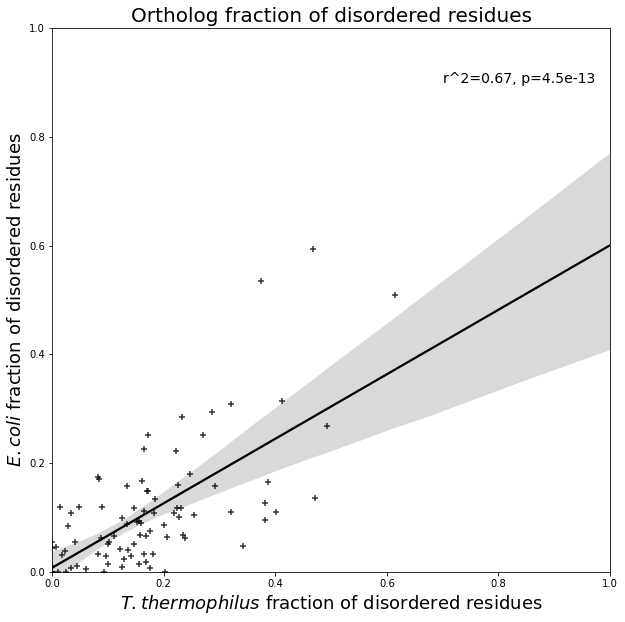

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_binary_mean,
                   'EC':IDP_pairs.EC_disorder_binary_mean,
                   'dis_len':(IDP_pairs.TT_longest_IDR + IDP_pairs.EC_longest_IDR) / 2})

ax.set_ylim(0,1)
ax.set_xlim(0,1)
sns.regplot(x=df.TT, y=df.EC, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog fraction of disordered residues', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('E. coli') + ' fraction of disordered residues', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('T. thermophilus') + ' fraction of disordered residues', fontsize=18)

rsq = pearsonr(df.TT, df.EC)

ax.text(0.7, 0.9, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog fraction of disordered residues.svg')

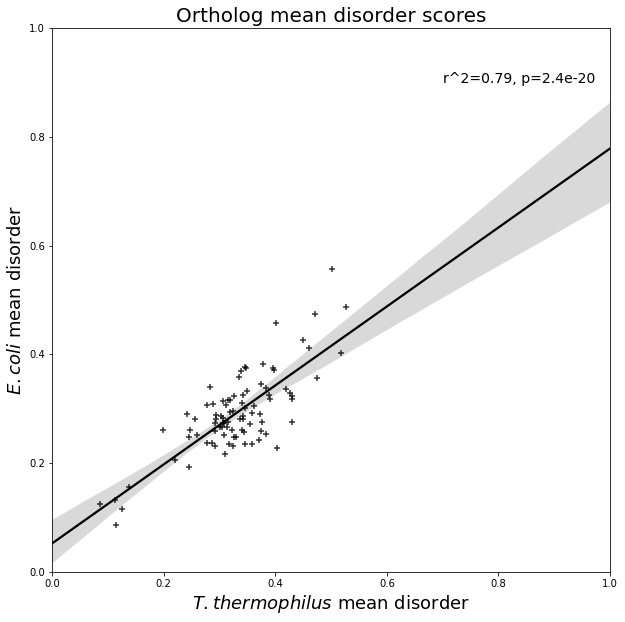

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_mean,
                   'EC':IDP_pairs.EC_disorder_mean,
                   'dis_len':(IDP_pairs.TT_longest_IDR + IDP_pairs.EC_longest_IDR) / 2})

ax.set_ylim(0,1)
ax.set_xlim(0,1)
sns.regplot(x=df.TT, y=df.EC, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog mean disorder scores', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('E. coli') + ' mean disorder', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('T. thermophilus') + ' mean disorder', fontsize=18)

rsq = pearsonr(df.TT, df.EC)

ax.text(0.7, 0.9, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog mean disorder scores.svg')

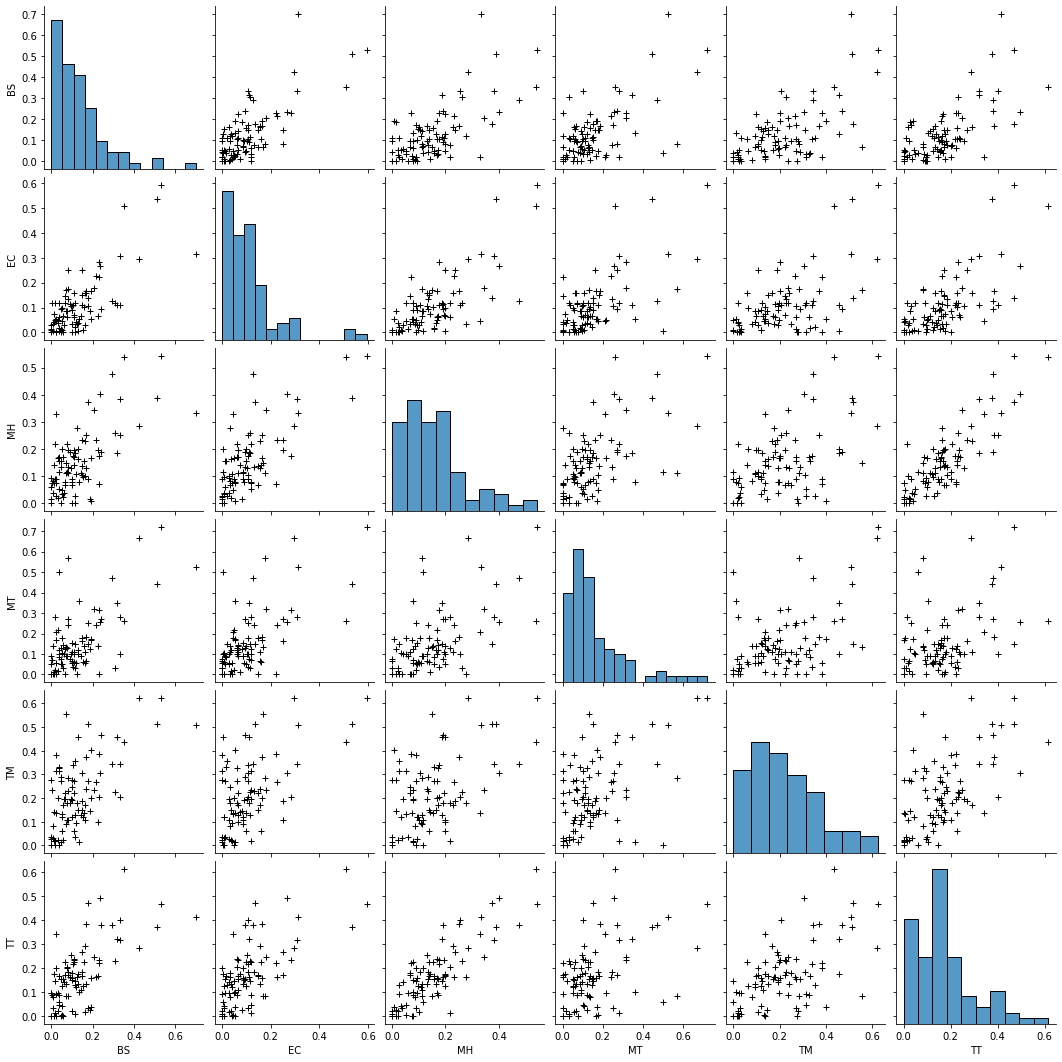

In [ ]:
df = pd.DataFrame({'BS':IDP_pairs.BS_disorder_binary_mean,
                   'EC':IDP_pairs.EC_disorder_binary_mean,
                   'MH':IDP_pairs.MH_disorder_binary_mean,
                   'MT':IDP_pairs.MT_disorder_binary_mean,
                   'TM':IDP_pairs.TM_disorder_binary_mean,
                   'TT':IDP_pairs.TT_disorder_binary_mean})

sns.pairplot(df, plot_kws=dict(marker="+", linewidth=1, color='black'))

In [ ]:
for i in ['BS', 'EC', 'MH', 'MT', 'TM']:
  for j in ['EC', 'MH', 'MT', 'TM', 'TT']:
    if i != j:
      rsq = pearsonr(df[i], df[j])
      print(i, j, round(rsq[0], 3), round(rsq[1], 10), sep=' - ')

BS - EC - 0.74 - 0.0
BS - MH - 0.662 - 0.0
BS - MT - 0.634 - 0.0
BS - TM - 0.606 - 3e-10
BS - TT - 0.669 - 0.0
EC - MH - 0.727 - 0.0
EC - MT - 0.627 - 0.0
EC - TM - 0.543 - 3.76e-08
EC - TT - 0.674 - 0.0
MH - EC - 0.727 - 0.0
MH - MT - 0.571 - 5.1e-09
MH - TM - 0.502 - 5.266e-07
MH - TT - 0.841 - 0.0
MT - EC - 0.627 - 0.0
MT - MH - 0.571 - 5.1e-09
MT - TM - 0.465 - 4.4521e-06
MT - TT - 0.436 - 1.97382e-05
TM - EC - 0.543 - 3.76e-08
TM - MH - 0.502 - 5.266e-07
TM - MT - 0.465 - 4.4521e-06
TM - TT - 0.579 - 2.7e-09


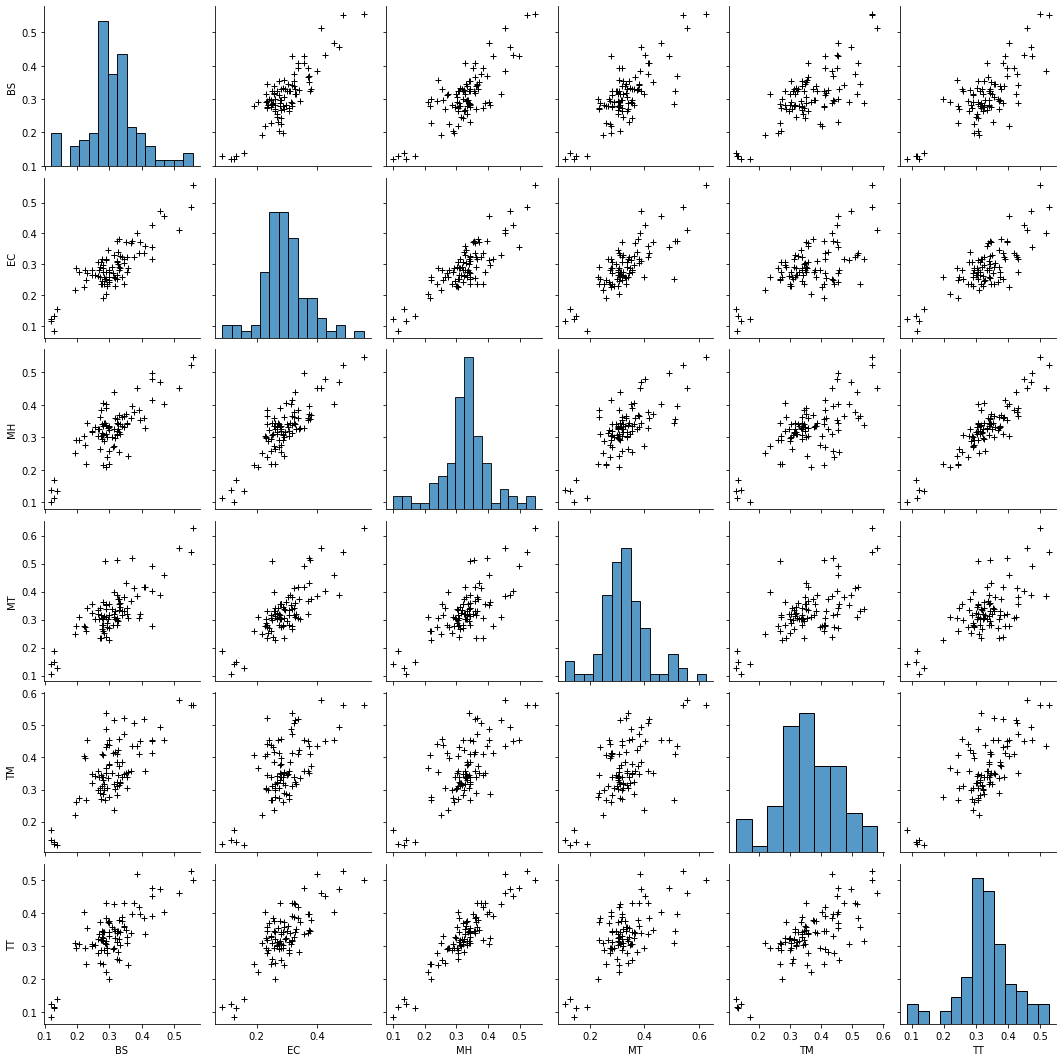

In [ ]:
df = pd.DataFrame({'BS':IDP_pairs.BS_disorder_mean,
                   'EC':IDP_pairs.EC_disorder_mean,
                   'MH':IDP_pairs.MH_disorder_mean,
                   'MT':IDP_pairs.MT_disorder_mean,
                   'TM':IDP_pairs.TM_disorder_mean,
                   'TT':IDP_pairs.TT_disorder_mean})

sns.pairplot(df, plot_kws=dict(marker="+", linewidth=1, color='black'))

In [ ]:
for i in ['BS', 'EC', 'MH', 'MT', 'TM']:
  for j in ['EC', 'MH', 'MT', 'TM', 'TT']:
    if i != j:
      rsq = pearsonr(df[i], df[j])
      print(i, j, round(rsq[0], 3), round(rsq[1], 10), sep=' - ')

BS - EC - 0.853 - 0.0
BS - MH - 0.799 - 0.0
BS - MT - 0.781 - 0.0
BS - TM - 0.73 - 0.0
BS - TT - 0.77 - 0.0
EC - MH - 0.845 - 0.0
EC - MT - 0.798 - 0.0
EC - TM - 0.659 - 0.0
EC - TT - 0.792 - 0.0
MH - EC - 0.845 - 0.0
MH - MT - 0.753 - 0.0
MH - TM - 0.708 - 0.0
MH - TT - 0.914 - 0.0
MT - EC - 0.798 - 0.0
MT - MH - 0.753 - 0.0
MT - TM - 0.633 - 0.0
MT - TT - 0.687 - 0.0
TM - EC - 0.659 - 0.0
TM - MH - 0.708 - 0.0
TM - MT - 0.633 - 0.0
TM - TT - 0.74 - 0.0


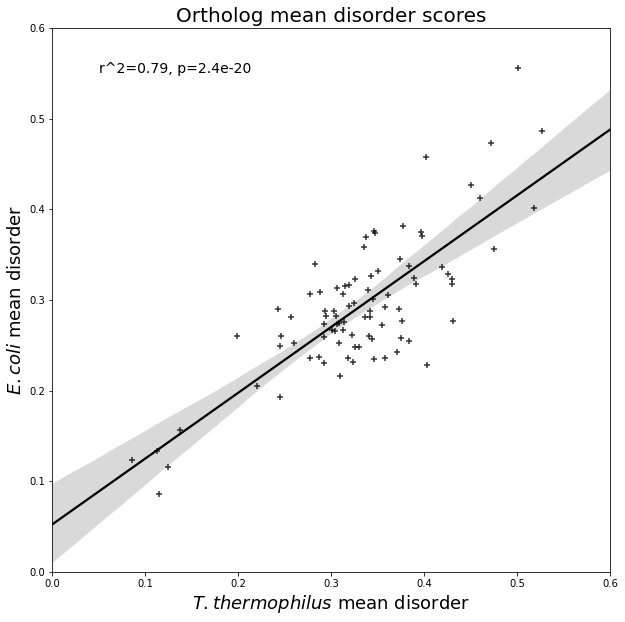

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_mean,
                   'EC':IDP_pairs.EC_disorder_mean,
                   'dis_len':(IDP_pairs.TT_longest_IDR + IDP_pairs.EC_longest_IDR) / 2})

ax.set_ylim(0,.6)
ax.set_xlim(0,.6)
sns.regplot(x=df.TT, y=df.EC, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog mean disorder scores', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('E. coli') + ' mean disorder', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('T. thermophilus') + ' mean disorder', fontsize=18)

rsq = pearsonr(df.TT, df.EC)

ax.text(0.05, 0.55, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog mean disorder scores: TT - EC.svg')

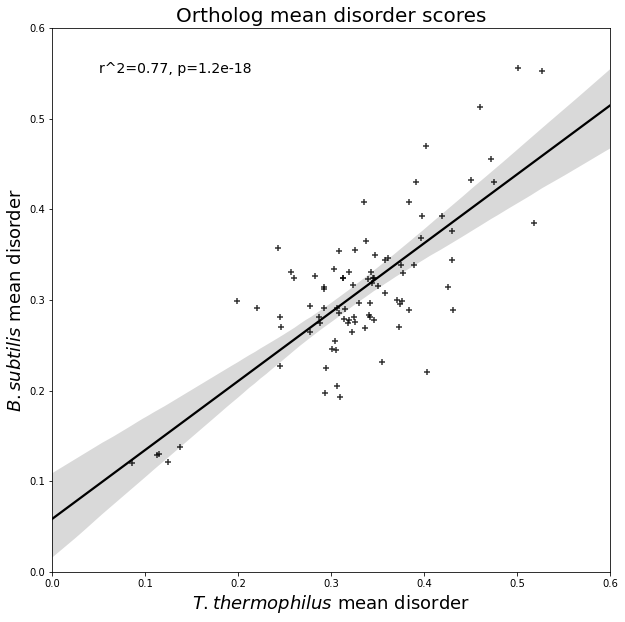

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_mean,
                   'BS':IDP_pairs.BS_disorder_mean,
                   'dis_len':(IDP_pairs.TT_longest_IDR + IDP_pairs.BS_longest_IDR) / 2})

ax.set_ylim(0,.6)
ax.set_xlim(0,.6)
sns.regplot(x=df.TT, y=df.BS, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog mean disorder scores', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('B. subtilis') + ' mean disorder', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('T. thermophilus') + ' mean disorder', fontsize=18)

rsq = pearsonr(df.TT, df.BS)

ax.text(0.05, 0.55, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog mean disorder scores: TT - BS.svg')

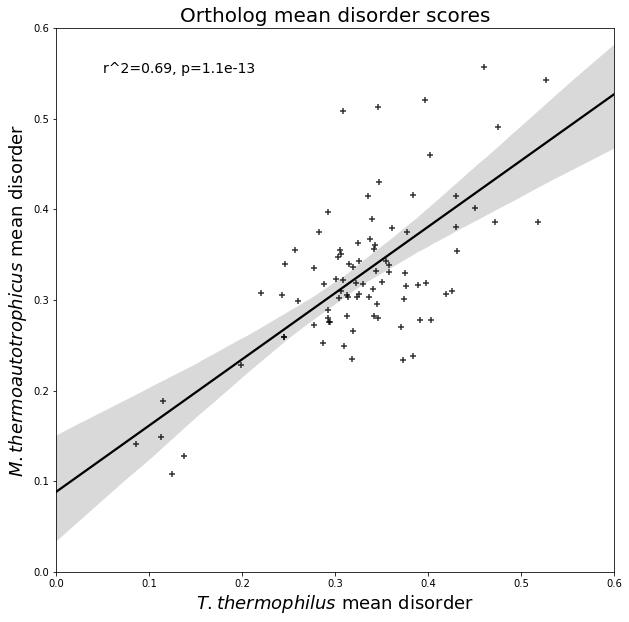

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_mean,
                   'MT':IDP_pairs.MT_disorder_mean,
                   'dis_len':(IDP_pairs.TT_longest_IDR + IDP_pairs.MT_longest_IDR) / 2})

ax.set_ylim(0,.6)
ax.set_xlim(0,.6)
sns.regplot(x=df.TT, y=df.MT, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog mean disorder scores', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('M. thermoautotrophicus') + ' mean disorder', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('T. thermophilus') + ' mean disorder', fontsize=18)

rsq = pearsonr(df.TT, df.MT)

ax.text(0.05, 0.55, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog mean disorder scores: TT - MT.svg')

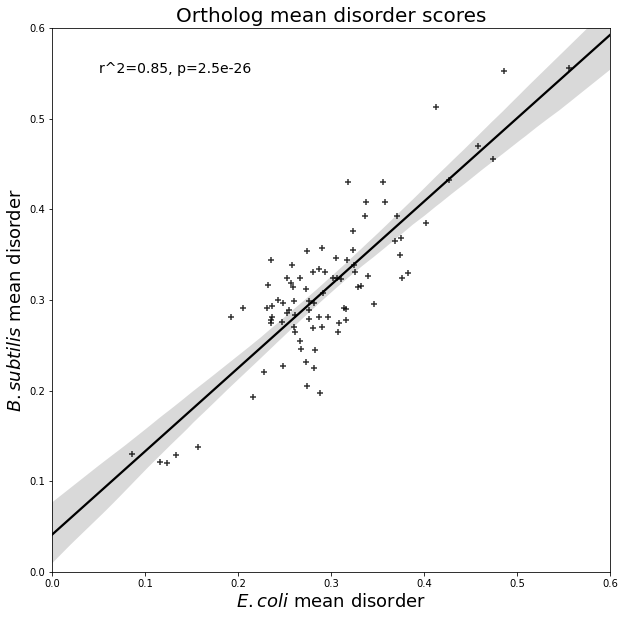

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'EC':IDP_pairs.EC_disorder_mean,
                   'BS':IDP_pairs.BS_disorder_mean,
                   'dis_len':(IDP_pairs.EC_longest_IDR + IDP_pairs.BS_longest_IDR) / 2})

ax.set_ylim(0,.6)
ax.set_xlim(0,.6)
sns.regplot(x=df.EC, y=df.BS, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog mean disorder scores', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('B. subtilis') + ' mean disorder', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('E. coli') + ' mean disorder', fontsize=18)

rsq = pearsonr(df.EC, df.BS)

ax.text(0.05, 0.55, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog mean disorder scores: EC - BS.svg')

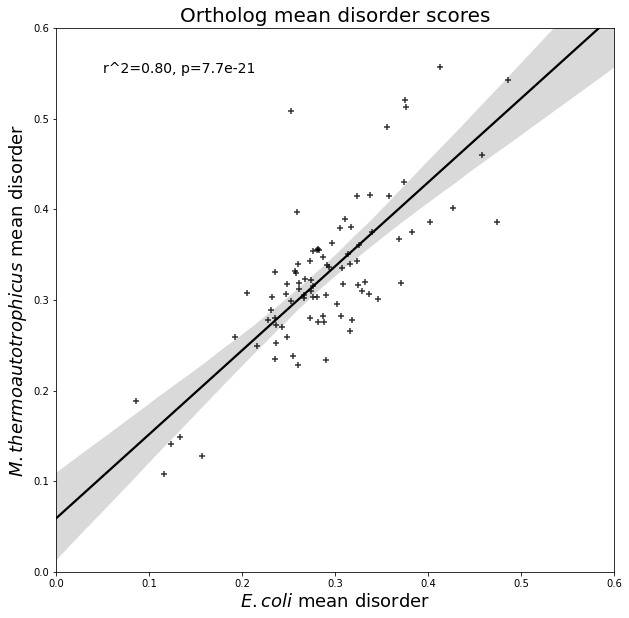

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'EC':IDP_pairs.EC_disorder_mean,
                   'MT':IDP_pairs.MT_disorder_mean,
                   'dis_len':(IDP_pairs.EC_longest_IDR + IDP_pairs.MT_longest_IDR) / 2})

ax.set_ylim(0,.6)
ax.set_xlim(0,.6)
sns.regplot(x=df.EC, y=df.MT, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog mean disorder scores', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('M. thermoautotrophicus') + ' mean disorder', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('E. coli') + ' mean disorder', fontsize=18)

rsq = pearsonr(df.EC, df.MT)

ax.text(0.05, 0.55, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog mean disorder scores: EC - MT.svg')

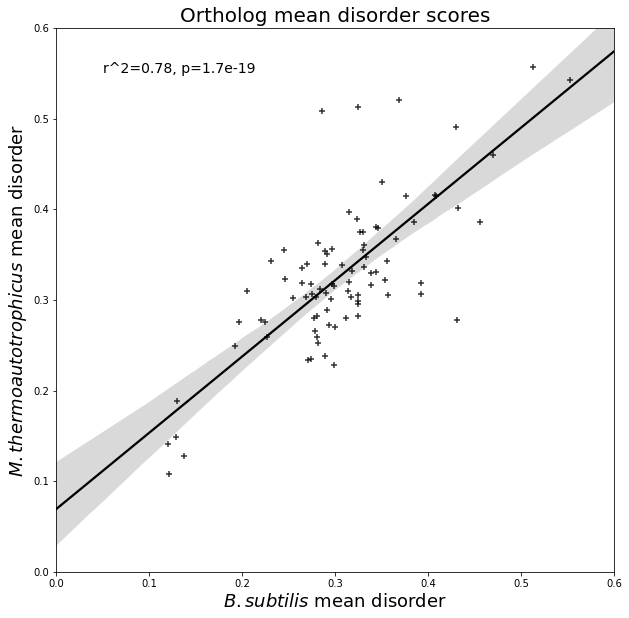

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'BS':IDP_pairs.BS_disorder_mean,
                   'MT':IDP_pairs.MT_disorder_mean,
                   'dis_len':(IDP_pairs.BS_longest_IDR + IDP_pairs.MT_longest_IDR) / 2})

ax.set_ylim(0,.6)
ax.set_xlim(0,.6)
sns.regplot(x=df.BS, y=df.MT, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog mean disorder scores', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('M. thermoautotrophicus') + ' mean disorder', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('B. subtilis') + ' mean disorder', fontsize=18)

rsq = pearsonr(df.BS, df.MT)

ax.text(0.05, 0.55, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog mean disorder scores: BS - MT.svg')

### Separate models

#### Whole proteomes

In [ ]:
BS_separate_models_means = {}
for m in models:
  BS_separate_models_means[m] = [np.mean(BS_proteome.disorder.iloc[n][m]) for n in range(len(BS_proteome))]
BS_separate_models_means = pd.DataFrame(BS_separate_models_means).melt(var_name='model', value_name='mean_disorder')

EC_separate_models_means = {}
for m in models:
  EC_separate_models_means[m] = [np.mean(EC_proteome.disorder.iloc[n][m]) for n in range(len(EC_proteome))]
EC_separate_models_means = pd.DataFrame(EC_separate_models_means).melt(var_name='model', value_name='mean_disorder')

MH_separate_models_means = {}
for m in models:
  MH_separate_models_means[m] = [np.mean(MH_proteome.disorder.iloc[n][m]) for n in range(len(MH_proteome))]
MH_separate_models_means = pd.DataFrame(MH_separate_models_means).melt(var_name='model', value_name='mean_disorder')

MT_separate_models_means = {}
for m in models:
  MT_separate_models_means[m] = [np.mean(MT_proteome.disorder.iloc[n][m]) for n in range(len(MT_proteome))]
MT_separate_models_means = pd.DataFrame(MT_separate_models_means).melt(var_name='model', value_name='mean_disorder')

TM_separate_models_means = {}
for m in models:
  TM_separate_models_means[m] = [np.mean(TM_proteome.disorder.iloc[n][m]) for n in range(len(TM_proteome))]
TM_separate_models_means = pd.DataFrame(TM_separate_models_means).melt(var_name='model', value_name='mean_disorder')

TT_separate_models_means = {}
for m in models:
  TT_separate_models_means[m] = [np.mean(TT_proteome.disorder.iloc[n][m]) for n in range(len(TT_proteome))]
TT_separate_models_means = pd.DataFrame(TT_separate_models_means).melt(var_name='model', value_name='mean_disorder')

In [ ]:
BS_separate_models_means['species'] = species_names_s[0]
EC_separate_models_means['species'] = species_names_s[1]
MH_separate_models_means['species'] = species_names_s[2]
MT_separate_models_means['species'] = species_names_s[3]
TM_separate_models_means['species'] = species_names_s[4]
TT_separate_models_means['species'] = species_names_s[5]

In [ ]:
model_means = pd.concat([BS_separate_models_means, EC_separate_models_means,
                         MH_separate_models_means, MT_separate_models_means,
                         TM_separate_models_means, TT_separate_models_means])

In [ ]:
model_means.groupby(['model', 'species']).mean()

mean_disorder
model   species                            
VL3     B.subtilis                 0.282780
        E.coli                     0.241938
        M.hydrothermalis           0.288525
        M.thermautotrophicus       0.295380
        T.marianensis              0.349759
        T.thermophilus             0.343833
VLXT    B.subtilis                 0.281981
        E.coli                     0.291521
        M.hydrothermalis           0.376702
        M.thermautotrophicus       0.353267
        T.marianensis              0.421406
        T.thermophilus             0.398882
VSL2    B.subtilis                 0.363251
        E.coli                     0.334590
        M.hydrothermalis           0.348315
        M.thermautotrophicus       0.358250
        T.marianensis              0.411251
        T.thermophilus             0.384199
iupred3 B.subtilis                 0.209962
        E.coli                     0.205584
        M.hydrothermalis           0.211035
        M.thermautotrophicus       0.198959
        T.marianensis              0.288746
        T.thermophilus             0.205949

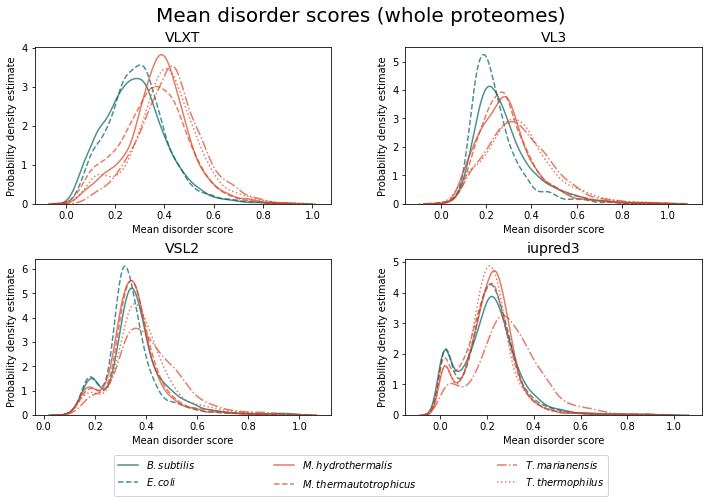

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,7))
plt.tight_layout()

for m, ax in zip(models, axs.flat):
  df = model_means[model_means.model==m]
  ax.set_title(m, fontsize=14)
  sns.kdeplot(df[df.species==species_names_s[0]].mean_disorder, color=colors[0], linestyle=linestyles[0],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[0]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[1]].mean_disorder, color=colors[1], linestyle=linestyles[1],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[1]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[2]].mean_disorder, color=colors[2], linestyle=linestyles[2],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[2]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[3]].mean_disorder, color=colors[3], linestyle=linestyles[3],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[3]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[4]].mean_disorder, color=colors[4], linestyle=linestyles[4],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[4]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[5]].mean_disorder, color=colors[5], linestyle=linestyles[5],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[5]), ax=ax)
  ax.set_ylabel('Probability density estimate', fontsize=10)
  ax.set_xlabel('Mean disorder score', fontsize=10)
plt.legend(bbox_to_anchor=(0.15, 0, 0.70, 0), loc='lower left', mode='expand', ncol=3, bbox_transform=fig.transFigure)
plt.subplots_adjust(bottom=0.17, top=0.90, wspace=0.25, hspace=0.35)
plt.suptitle('Mean disorder scores (whole proteomes)', size=20)

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(ttest_ind(df[df.species==species_names_s[0]].mean_disorder, df[df.species==species_names_s[1]].mean_disorder, nan_policy='omit'))
# print(ttest_ind(df[df.species==species_names_s[0]].mean_disorder, df[df.species==species_names_s[2]].mean_disorder, nan_policy='omit'))
# print(ttest_ind(df[df.species==species_names_s[0]].mean_disorder, df[df.species==species_names_s[3]].mean_disorder, nan_policy='omit'))
# print(ttest_ind(df[df.species==species_names_s[1]].mean_disorder, df[df.species==species_names_s[2]].mean_disorder, nan_policy='omit'))
# print(ttest_ind(df[df.species==species_names_s[1]].mean_disorder, df[df.species==species_names_s[3]].mean_disorder, nan_policy='omit'))
# print(ttest_ind(df[df.species==species_names_s[2]].mean_disorder, df[df.species==species_names_s[3]].mean_disorder, nan_policy='omit'))
# # print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig('Mean disorder scores (whole proteomes) - separate models.svg')

In [ ]:
BS_separate_models_binary = {}
for m in models:
  BS_separate_models_binary[m] = [np.mean(binary_disorder(BS_proteome.disorder.iloc[n][m])) for n in range(len(BS_proteome))]
BS_separate_models_binary = pd.DataFrame(BS_separate_models_binary).melt(var_name='model', value_name='binary_disorder')

EC_separate_models_binary = {}
for m in models:
  EC_separate_models_binary[m] = [np.mean(binary_disorder(EC_proteome.disorder.iloc[n][m])) for n in range(len(EC_proteome))]
EC_separate_models_binary = pd.DataFrame(EC_separate_models_binary).melt(var_name='model', value_name='binary_disorder')

MH_separate_models_binary = {}
for m in models:
  MH_separate_models_binary[m] = [np.mean(binary_disorder(MH_proteome.disorder.iloc[n][m])) for n in range(len(MH_proteome))]
MH_separate_models_binary = pd.DataFrame(MH_separate_models_binary).melt(var_name='model', value_name='binary_disorder')

MT_separate_models_binary = {}
for m in models:
  MT_separate_models_binary[m] = [np.mean(binary_disorder(MT_proteome.disorder.iloc[n][m])) for n in range(len(MT_proteome))]
MT_separate_models_binary = pd.DataFrame(MT_separate_models_binary).melt(var_name='model', value_name='binary_disorder')

TM_separate_models_binary = {}
for m in models:
  TM_separate_models_binary[m] = [np.mean(binary_disorder(TM_proteome.disorder.iloc[n][m])) for n in range(len(TM_proteome))]
TM_separate_models_binary = pd.DataFrame(TM_separate_models_binary).melt(var_name='model', value_name='binary_disorder')

TT_separate_models_binary = {}
for m in models:
  TT_separate_models_binary[m] = [np.mean(binary_disorder(TT_proteome.disorder.iloc[n][m])) for n in range(len(TT_proteome))]
TT_separate_models_binary = pd.DataFrame(TT_separate_models_binary).melt(var_name='model', value_name='binary_disorder')

In [ ]:
BS_separate_models_binary['species'] = species_names_s[0]
EC_separate_models_binary['species'] = species_names_s[1]
MH_separate_models_binary['species'] = species_names_s[2]
MT_separate_models_binary['species'] = species_names_s[3]
TM_separate_models_binary['species'] = species_names_s[4]
TT_separate_models_binary['species'] = species_names_s[5]

In [ ]:
model_binary = pd.concat([BS_separate_models_binary, EC_separate_models_binary,
                         MH_separate_models_binary, MT_separate_models_binary,
                         TM_separate_models_binary, TT_separate_models_binary])

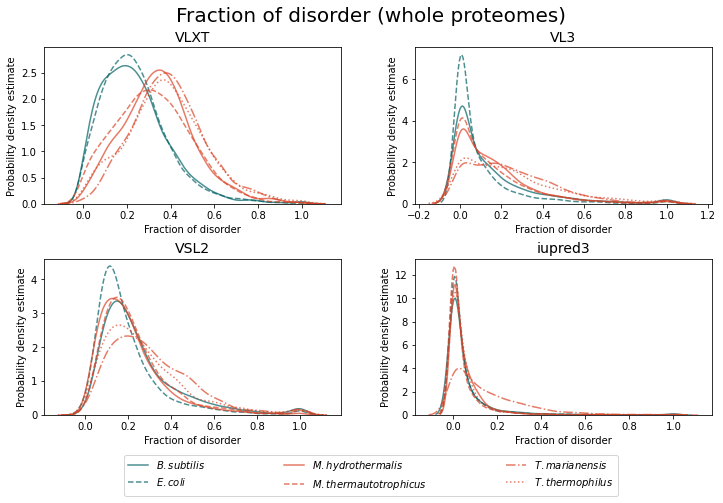

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,7))
plt.tight_layout()

for m, ax in zip(models, axs.flat):
  df = model_binary[model_binary.model==m]
  ax.set_title(m, fontsize=14)
  sns.kdeplot(df[df.species==species_names_s[0]].binary_disorder, color=colors[0], linestyle=linestyles[0],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[0]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[1]].binary_disorder, color=colors[1], linestyle=linestyles[1],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[1]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[2]].binary_disorder, color=colors[2], linestyle=linestyles[2],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[2]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[3]].binary_disorder, color=colors[3], linestyle=linestyles[3],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[3]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[4]].binary_disorder, color=colors[4], linestyle=linestyles[4],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[4]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[5]].binary_disorder, color=colors[5], linestyle=linestyles[5],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[5]), ax=ax)
  ax.set_ylabel('Probability density estimate', fontsize=10)
  ax.set_xlabel('Fraction of disorder', fontsize=10)
plt.legend(bbox_to_anchor=(0.15, 0, 0.70, 0), loc='lower left', mode='expand', ncol=3, bbox_transform=fig.transFigure)
plt.subplots_adjust(bottom=0.17, top=0.90, wspace=0.25, hspace=0.35)
plt.suptitle('Fraction of disorder (whole proteomes)', size=20)

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(ttest_ind(df[df.species==species_names_s[0]].mean_disorder, df[df.species==species_names_s[1]].mean_disorder, nan_policy='omit'))
# print(ttest_ind(df[df.species==species_names_s[0]].mean_disorder, df[df.species==species_names_s[2]].mean_disorder, nan_policy='omit'))
# print(ttest_ind(df[df.species==species_names_s[0]].mean_disorder, df[df.species==species_names_s[3]].mean_disorder, nan_policy='omit'))
# print(ttest_ind(df[df.species==species_names_s[1]].mean_disorder, df[df.species==species_names_s[2]].mean_disorder, nan_policy='omit'))
# print(ttest_ind(df[df.species==species_names_s[1]].mean_disorder, df[df.species==species_names_s[3]].mean_disorder, nan_policy='omit'))
# print(ttest_ind(df[df.species==species_names_s[2]].mean_disorder, df[df.species==species_names_s[3]].mean_disorder, nan_policy='omit'))
# # print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig('Fraction of disordered residues (whole proteomes) - separate models.svg')

#### Orthologs

In [ ]:
BS_separate_models_orthologs_means = {}
for m in models:
  BS_separate_models_orthologs_means[m] = [IDP_pairs.BS_disorder.iloc[i][m].mean() for i in range(len(IDP_pairs))]
BS_separate_models_orthologs_means = pd.DataFrame(BS_separate_models_orthologs_means).melt(var_name='model', value_name='mean_disorder')

EC_separate_models_orthologs_means = {}
for m in models:
  EC_separate_models_orthologs_means[m] = [IDP_pairs.EC_disorder.iloc[i][m].mean() for i in range(len(IDP_pairs))]
EC_separate_models_orthologs_means = pd.DataFrame(EC_separate_models_orthologs_means).melt(var_name='model', value_name='mean_disorder')

MH_separate_models_orthologs_means = {}
for m in models:
  MH_separate_models_orthologs_means[m] = [IDP_pairs.MH_disorder.iloc[i][m].mean() for i in range(len(IDP_pairs))]
MH_separate_models_orthologs_means = pd.DataFrame(MH_separate_models_orthologs_means).melt(var_name='model', value_name='mean_disorder')

MT_separate_models_orthologs_means = {}
for m in models:
  MT_separate_models_orthologs_means[m] = [IDP_pairs.MT_disorder.iloc[i][m].mean() for i in range(len(IDP_pairs))]
MT_separate_models_orthologs_means = pd.DataFrame(MT_separate_models_orthologs_means).melt(var_name='model', value_name='mean_disorder')

TM_separate_models_orthologs_means = {}
for m in models:
  TM_separate_models_orthologs_means[m] = [IDP_pairs.TM_disorder.iloc[i][m].mean() for i in range(len(IDP_pairs))]
TM_separate_models_orthologs_means = pd.DataFrame(TM_separate_models_orthologs_means).melt(var_name='model', value_name='mean_disorder')

TT_separate_models_orthologs_means = {}
for m in models:
  TT_separate_models_orthologs_means[m] = [IDP_pairs.TT_disorder.iloc[i][m].mean() for i in range(len(IDP_pairs))]
TT_separate_models_orthologs_means = pd.DataFrame(TT_separate_models_orthologs_means).melt(var_name='model', value_name='mean_disorder')

In [ ]:
BS_separate_models_orthologs_means['species'] = species_names_s[0]
EC_separate_models_orthologs_means['species'] = species_names_s[1]
MH_separate_models_orthologs_means['species'] = species_names_s[2]
MT_separate_models_orthologs_means['species'] = species_names_s[3]
TM_separate_models_orthologs_means['species'] = species_names_s[4]
TT_separate_models_orthologs_means['species'] = species_names_s[5]

In [ ]:
model_orthologs_means = pd.concat([BS_separate_models_orthologs_means, EC_separate_models_orthologs_means,
                                   MH_separate_models_orthologs_means, MT_separate_models_orthologs_means,
                                   TM_separate_models_orthologs_means, TT_separate_models_orthologs_means])

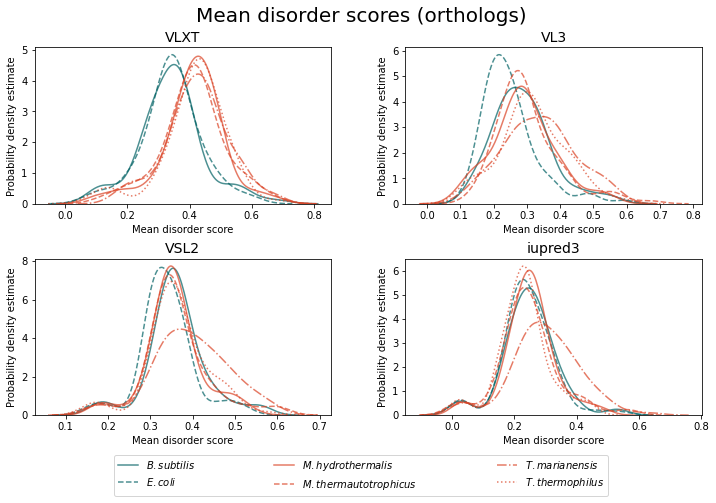

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,7))
plt.tight_layout()

for m, ax in zip(models, axs.flat):
  df = model_orthologs_means[model_orthologs_means.model==m]
  ax.set_title(m, fontsize=14)
  sns.kdeplot(df[df.species==species_names_s[0]].mean_disorder, color=colors[0], linestyle=linestyles[0],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[0]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[1]].mean_disorder, color=colors[1], linestyle=linestyles[1],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[1]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[2]].mean_disorder, color=colors[2], linestyle=linestyles[2],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[2]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[3]].mean_disorder, color=colors[3], linestyle=linestyles[3],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[3]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[4]].mean_disorder, color=colors[4], linestyle=linestyles[4],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[4]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[5]].mean_disorder, color=colors[5], linestyle=linestyles[5],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[5]), ax=ax)
  ax.set_ylabel('Probability density estimate', fontsize=10)
  ax.set_xlabel('Mean disorder score', fontsize=10)
plt.legend(bbox_to_anchor=(0.15, 0, 0.70, 0), loc='lower left', mode='expand', ncol=3, bbox_transform=fig.transFigure)
plt.subplots_adjust(bottom=0.17, top=0.90, wspace=0.25, hspace=0.35)
plt.suptitle('Mean disorder scores (orthologs)', size=20)

fig.show()
fig.savefig('Mean disorder scores (orthologs) - separate models.svg')

In [ ]:
BS_separate_models_orthologs_binary = {}
for m in models:
  BS_separate_models_orthologs_binary[m] = [np.mean(IDP_pairs.BS_disorder.iloc[i][m]>0.5) for i in range(len(IDP_pairs))]
BS_separate_models_orthologs_binary = pd.DataFrame(BS_separate_models_orthologs_binary).melt(var_name='model', value_name='binary_disorder')

EC_separate_models_orthologs_binary = {}
for m in models:
  EC_separate_models_orthologs_binary[m] = [np.mean(IDP_pairs.EC_disorder.iloc[i][m]>0.5) for i in range(len(IDP_pairs))]
EC_separate_models_orthologs_binary = pd.DataFrame(EC_separate_models_orthologs_binary).melt(var_name='model', value_name='binary_disorder')

MH_separate_models_orthologs_binary = {}
for m in models:
  MH_separate_models_orthologs_binary[m] = [np.mean(IDP_pairs.MH_disorder.iloc[i][m]>0.5) for i in range(len(IDP_pairs))]
MH_separate_models_orthologs_binary = pd.DataFrame(MH_separate_models_orthologs_binary).melt(var_name='model', value_name='binary_disorder')

MT_separate_models_orthologs_binary = {}
for m in models:
  MT_separate_models_orthologs_binary[m] = [np.mean(IDP_pairs.MT_disorder.iloc[i][m]>0.5) for i in range(len(IDP_pairs))]
MT_separate_models_orthologs_binary = pd.DataFrame(MT_separate_models_orthologs_binary).melt(var_name='model', value_name='binary_disorder')

TM_separate_models_orthologs_binary = {}
for m in models:
  TM_separate_models_orthologs_binary[m] = [np.mean(IDP_pairs.TM_disorder.iloc[i][m]>0.5) for i in range(len(IDP_pairs))]
TM_separate_models_orthologs_binary = pd.DataFrame(TM_separate_models_orthologs_binary).melt(var_name='model', value_name='binary_disorder')

TT_separate_models_orthologs_binary = {}
for m in models:
  TT_separate_models_orthologs_binary[m] = [np.mean(IDP_pairs.TT_disorder.iloc[i][m]>0.5) for i in range(len(IDP_pairs))]
TT_separate_models_orthologs_binary = pd.DataFrame(TT_separate_models_orthologs_binary).melt(var_name='model', value_name='binary_disorder')

In [ ]:
BS_separate_models_orthologs_binary['species'] = species_names_s[0]
EC_separate_models_orthologs_binary['species'] = species_names_s[1]
MH_separate_models_orthologs_binary['species'] = species_names_s[2]
MT_separate_models_orthologs_binary['species'] = species_names_s[3]
TM_separate_models_orthologs_binary['species'] = species_names_s[4]
TT_separate_models_orthologs_binary['species'] = species_names_s[5]

In [ ]:
model_orthologs_binary = pd.concat([BS_separate_models_orthologs_binary, EC_separate_models_orthologs_binary,
                                   MH_separate_models_orthologs_binary, MT_separate_models_orthologs_binary,
                                   TM_separate_models_orthologs_binary, TT_separate_models_orthologs_binary])

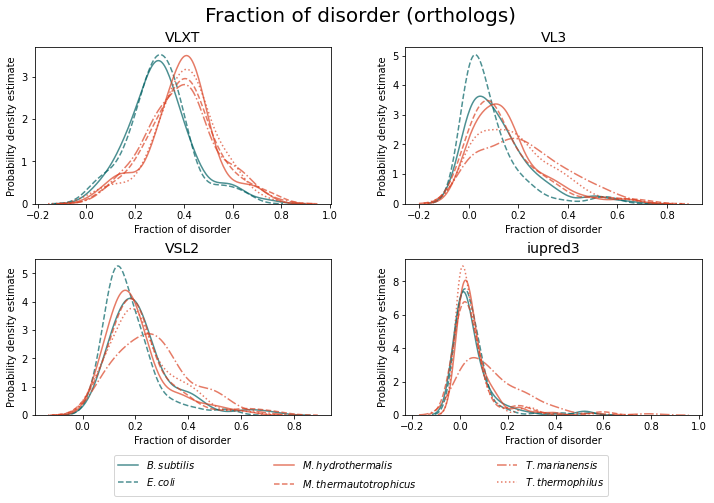

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,7))
plt.tight_layout()

for m, ax in zip(models, axs.flat):
  df = model_orthologs_binary[model_orthologs_binary.model==m]
  ax.set_title(m, fontsize=14)
  sns.kdeplot(df[df.species==species_names_s[0]].binary_disorder, color=colors[0], linestyle=linestyles[0],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[0]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[1]].binary_disorder, color=colors[1], linestyle=linestyles[1],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[1]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[2]].binary_disorder, color=colors[2], linestyle=linestyles[2],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[2]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[3]].binary_disorder, color=colors[3], linestyle=linestyles[3],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[3]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[4]].binary_disorder, color=colors[4], linestyle=linestyles[4],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[4]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[5]].binary_disorder, color=colors[5], linestyle=linestyles[5],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[5]), ax=ax)
  ax.set_ylabel('Probability density estimate', fontsize=10)
  ax.set_xlabel('Fraction of disorder', fontsize=10)
plt.legend(bbox_to_anchor=(0.15, 0, 0.70, 0), loc='lower left', mode='expand', ncol=3, bbox_transform=fig.transFigure)
plt.subplots_adjust(bottom=0.17, top=0.90, wspace=0.25, hspace=0.35)
plt.suptitle('Fraction of disorder (orthologs)', size=20)

fig.show()
fig.savefig('Fraction of disordered residues (orthologs) - separate models.svg')

#### Exclusive

In [ ]:
BS_separate_models_exclusive_means = {}
for m in models:
  BS_separate_models_exclusive_means[m] = [BS_only.disorder.iloc[i][m].mean() for i in range(len(BS_only))]
BS_separate_models_exclusive_means = pd.DataFrame(BS_separate_models_exclusive_means).melt(var_name='model', value_name='mean_disorder')

EC_separate_models_exclusive_means = {}
for m in models:
  EC_separate_models_exclusive_means[m] = [EC_only.disorder.iloc[i][m].mean() for i in range(len(EC_only))]
EC_separate_models_exclusive_means = pd.DataFrame(EC_separate_models_exclusive_means).melt(var_name='model', value_name='mean_disorder')

MH_separate_models_exclusive_means = {}
for m in models:
  MH_separate_models_exclusive_means[m] = [MH_only.disorder.iloc[i][m].mean() for i in range(len(MH_only))]
MH_separate_models_exclusive_means = pd.DataFrame(MH_separate_models_exclusive_means).melt(var_name='model', value_name='mean_disorder')

MT_separate_models_exclusive_means = {}
for m in models:
  MT_separate_models_exclusive_means[m] = [MT_only.disorder.iloc[i][m].mean() for i in range(len(MT_only))]
MT_separate_models_exclusive_means = pd.DataFrame(MT_separate_models_exclusive_means).melt(var_name='model', value_name='mean_disorder')

TM_separate_models_exclusive_means = {}
for m in models:
  TM_separate_models_exclusive_means[m] = [TM_only.disorder.iloc[i][m].mean() for i in range(len(TM_only))]
TM_separate_models_exclusive_means = pd.DataFrame(TM_separate_models_exclusive_means).melt(var_name='model', value_name='mean_disorder')

TT_separate_models_exclusive_means = {}
for m in models:
  TT_separate_models_exclusive_means[m] = [TT_only.disorder.iloc[i][m].mean() for i in range(len(TT_only))]
TT_separate_models_exclusive_means = pd.DataFrame(TT_separate_models_exclusive_means).melt(var_name='model', value_name='mean_disorder')

In [ ]:
BS_separate_models_exclusive_means['species'] = species_names_s[0]
EC_separate_models_exclusive_means['species'] = species_names_s[1]
MH_separate_models_exclusive_means['species'] = species_names_s[2]
MT_separate_models_exclusive_means['species'] = species_names_s[3]
TM_separate_models_exclusive_means['species'] = species_names_s[4]
TT_separate_models_exclusive_means['species'] = species_names_s[5]

In [ ]:
model_exclusive_means = pd.concat([BS_separate_models_exclusive_means, EC_separate_models_exclusive_means,
                                   MH_separate_models_exclusive_means, MT_separate_models_exclusive_means,
                                   TM_separate_models_exclusive_means, TT_separate_models_exclusive_means])

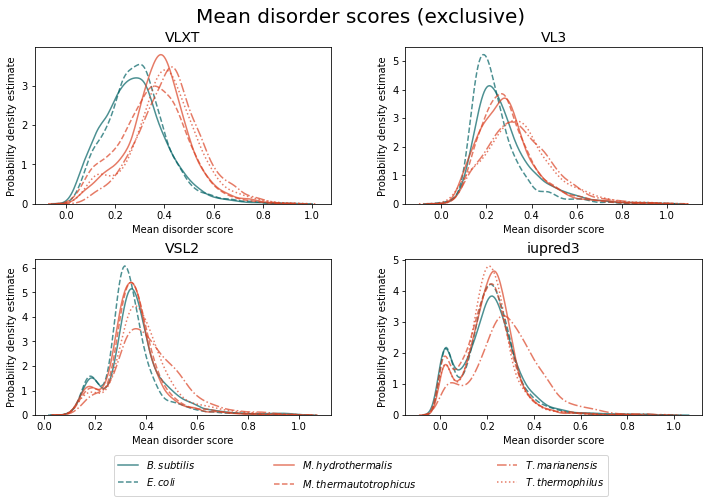

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,7))
plt.tight_layout()

for m, ax in zip(models, axs.flat):
  df = model_exclusive_means[model_exclusive_means.model==m]
  ax.set_title(m, fontsize=14)
  sns.kdeplot(df[df.species==species_names_s[0]].mean_disorder, color=colors[0], linestyle=linestyles[0],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[0]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[1]].mean_disorder, color=colors[1], linestyle=linestyles[1],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[1]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[2]].mean_disorder, color=colors[2], linestyle=linestyles[2],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[2]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[3]].mean_disorder, color=colors[3], linestyle=linestyles[3],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[3]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[4]].mean_disorder, color=colors[4], linestyle=linestyles[4],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[4]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[5]].mean_disorder, color=colors[5], linestyle=linestyles[5],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[5]), ax=ax)
  ax.set_ylabel('Probability density estimate', fontsize=10)
  ax.set_xlabel('Mean disorder score', fontsize=10)
plt.legend(bbox_to_anchor=(0.15, 0, 0.70, 0), loc='lower left', mode='expand', ncol=3, bbox_transform=fig.transFigure)
plt.subplots_adjust(bottom=0.17, top=0.90, wspace=0.25, hspace=0.35)
plt.suptitle('Mean disorder scores (exclusive)', size=20)

fig.show()
fig.savefig('Mean disorder scores (exclusive) - separate models.svg')

In [ ]:
BS_separate_models_exclusive_binary = {}
for m in models:
  BS_separate_models_exclusive_binary[m] = [np.mean(BS_only.disorder.iloc[i][m]>0.5) for i in range(len(BS_only))]
BS_separate_models_exclusive_binary = pd.DataFrame(BS_separate_models_exclusive_binary).melt(var_name='model', value_name='binary_disorder')

EC_separate_models_exclusive_binary = {}
for m in models:
  EC_separate_models_exclusive_binary[m] = [np.mean(EC_only.disorder.iloc[i][m]>0.5) for i in range(len(EC_only))]
EC_separate_models_exclusive_binary = pd.DataFrame(EC_separate_models_exclusive_binary).melt(var_name='model', value_name='binary_disorder')

MH_separate_models_exclusive_binary = {}
for m in models:
  MH_separate_models_exclusive_binary[m] = [np.mean(MH_only.disorder.iloc[i][m]>0.5) for i in range(len(MH_only))]
MH_separate_models_exclusive_binary = pd.DataFrame(MH_separate_models_exclusive_binary).melt(var_name='model', value_name='binary_disorder')

MT_separate_models_exclusive_binary = {}
for m in models:
  MT_separate_models_exclusive_binary[m] = [np.mean(MT_only.disorder.iloc[i][m]>0.5) for i in range(len(MT_only))]
MT_separate_models_exclusive_binary = pd.DataFrame(MT_separate_models_exclusive_binary).melt(var_name='model', value_name='binary_disorder')

TM_separate_models_exclusive_binary = {}
for m in models:
  TM_separate_models_exclusive_binary[m] = [np.mean(TM_only.disorder.iloc[i][m]>0.5) for i in range(len(TM_only))]
TM_separate_models_exclusive_binary = pd.DataFrame(TM_separate_models_exclusive_binary).melt(var_name='model', value_name='binary_disorder')

TT_separate_models_exclusive_binary = {}
for m in models:
  TT_separate_models_exclusive_binary[m] = [np.mean(TT_only.disorder.iloc[i][m]>0.5) for i in range(len(TT_only))]
TT_separate_models_exclusive_binary = pd.DataFrame(TT_separate_models_exclusive_binary).melt(var_name='model', value_name='binary_disorder')

In [ ]:
BS_separate_models_exclusive_binary['species'] = species_names_s[0]
EC_separate_models_exclusive_binary['species'] = species_names_s[1]
MH_separate_models_exclusive_binary['species'] = species_names_s[2]
MT_separate_models_exclusive_binary['species'] = species_names_s[3]
TM_separate_models_exclusive_binary['species'] = species_names_s[4]
TT_separate_models_exclusive_binary['species'] = species_names_s[5]

In [ ]:
model_exclusive_binary = pd.concat([BS_separate_models_exclusive_binary, EC_separate_models_exclusive_binary,
                                    MH_separate_models_exclusive_binary, MT_separate_models_exclusive_binary,
                                    TM_separate_models_exclusive_binary, TT_separate_models_exclusive_binary])

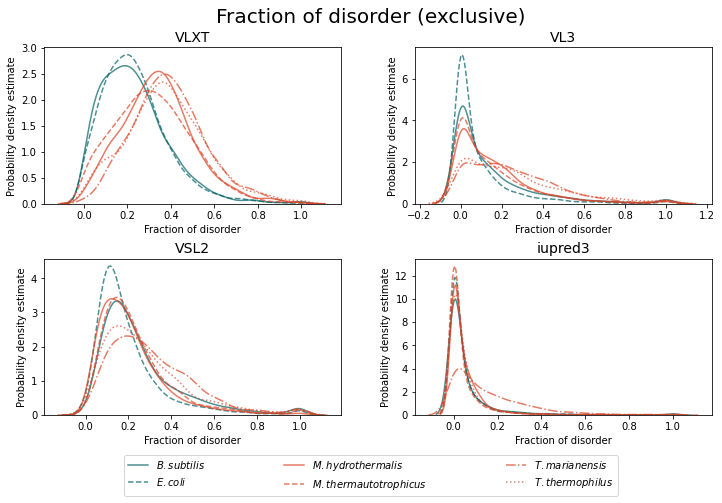

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,7))
plt.tight_layout()

for m, ax in zip(models, axs.flat):
  df = model_exclusive_binary[model_exclusive_binary.model==m]
  ax.set_title(m, fontsize=14)
  sns.kdeplot(df[df.species==species_names_s[0]].binary_disorder, color=colors[0], linestyle=linestyles[0],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[0]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[1]].binary_disorder, color=colors[1], linestyle=linestyles[1],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[1]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[2]].binary_disorder, color=colors[2], linestyle=linestyles[2],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[2]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[3]].binary_disorder, color=colors[3], linestyle=linestyles[3],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[3]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[4]].binary_disorder, color=colors[4], linestyle=linestyles[4],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[4]), ax=ax)
  sns.kdeplot(df[df.species==species_names_s[5]].binary_disorder, color=colors[5], linestyle=linestyles[5],
              alpha=0.7, label='$\\it{}$'.format(species_names_s[5]), ax=ax)
  ax.set_ylabel('Probability density estimate', fontsize=10)
  ax.set_xlabel('Fraction of disorder', fontsize=10)
plt.legend(bbox_to_anchor=(0.15, 0, 0.70, 0), loc='lower left', mode='expand', ncol=3, bbox_transform=fig.transFigure)
plt.subplots_adjust(bottom=0.17, top=0.90, wspace=0.25, hspace=0.35)
plt.suptitle('Fraction of disorder (exclusive)', size=20)

fig.show()
fig.savefig('Fraction of disordered residues (exclusive) - separate models.svg')

## Charge / hydrophobicity

We use a custom function to calculate mean net charge and mean hydrophobicity for the amino acid sequences. The calcuations are based on [Uversky et.al. 2000 paper](https://doi.org/10.1002/1097-0134(20001115)41:3%3C415::AID-PROT130%3E3.0.CO;2-7)

In [ ]:
for df in proteomes:
  df['charge_hydrophobicity'] = df.Sequence.apply(get_charge_hydrophobicity)
  df[['mean_net_charge', 'mean_hydrophobicity']] = pd.DataFrame(df['charge_hydrophobicity'].tolist(), index=df.index)
  df['Fraction of disorder'] = df.disorder_binary_mean * 100

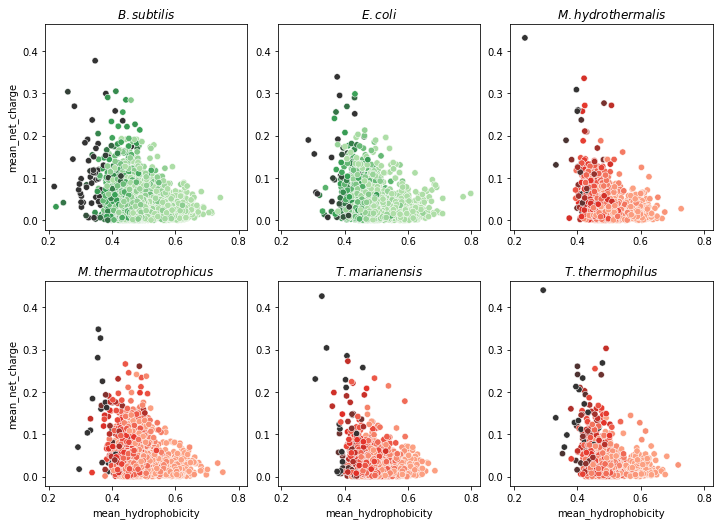

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7), sharex=True, sharey=True)
fig.tight_layout()

for i, ax in enumerate(axs.flat):
  if i < 2:
    palette = 'Greens_d'
  else:
    palette = 'Reds_d'
  sns.scatterplot(data=proteomes[i], x='mean_hydrophobicity', y='mean_net_charge', hue='Fraction of disorder', s=40, palette=palette, ax=ax, legend=False)
  ax.tick_params(labelbottom=True, labelleft=True)
  ax.set_title('$\\it{}$'.format(species_names_s[i]))

fig.subplots_adjust(hspace=0.25, wspace=0.15)
plt.show()
fig.savefig('CHplots.svg')
# files.download('CHplots.svg')

<ipython-input-91-d5c63f492dc8>:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


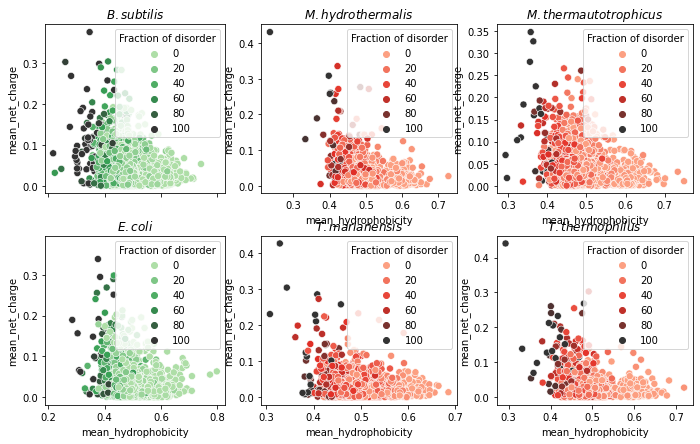

In [ ]:
fig = plt.figure(figsize=(10, 7))
axarr1 = fig.subplots(nrows=2, ncols=1, sharex=True, sharey=True, gridspec_kw=dict(left=0.05, right=0.30, wspace=0.2))
axarr2 = fig.subplots(nrows=2, ncols=2, gridspec_kw=dict(left=0.35, right=0.95, wspace=0.2))
fig.tight_layout()

for i, ax in enumerate(axarr1.flat):
    sns.scatterplot(data=[BS_proteome, EC_proteome][i], x='mean_hydrophobicity', y='mean_net_charge', hue='Fraction of disorder', s=50, palette='Greens_d', ax=ax)
    ax.set_title('$\\it{}$'.format(species_names_s[i]))

for i, ax in enumerate(axarr2.flat):
    sns.scatterplot(data=[MH_proteome, MT_proteome, TM_proteome, TT_proteome][i], x='mean_hydrophobicity', y='mean_net_charge', hue='Fraction of disorder', s=50, palette='Reds_d', ax=ax)
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_title('$\\it{}$'.format(species_names_s[i+2]))

fig.subplots_adjust(hspace=0.25, wspace=0.15)
plt.show()

In [ ]:
print('T. thermophilus median hydrophobicity: ' + str(TT_proteome.mean_hydrophobicity.median()))
print('T. thermophilus median charge: ' + str(TT_proteome.mean_net_charge.median()))
print('E. coli median hydrophobicity: ' + str(EC_proteome.mean_hydrophobicity.median()))
print('E. coli median charge: ' + str(EC_proteome.mean_net_charge.median()))
print('B. subtilis median hydrophobicity: ' + str(BS_proteome.mean_hydrophobicity.median()))
print('B. subtilis median charge: ' + str(BS_proteome.mean_net_charge.median()))
print('M. thermoautotrophic median hydrophobicity: ' + str(MT_proteome.mean_hydrophobicity.median()))
print('M. thermoautotrophic median charge: ' + str(MT_proteome.mean_net_charge.median()))

T. thermophilus median hydrophobicity: 0.48915470494417884
T. thermophilus median charge: 0.01760941429428782
E. coli median hydrophobicity: 0.4825268817204295
E. coli median charge: 0.022397669313049016
B. subtilis median hydrophobicity: 0.4701365817644884
B. subtilis median charge: 0.02737501474714723
M. thermoautotrophic median hydrophobicity: 0.4814153439153442
M. thermoautotrophic median charge: 0.03425514376535757


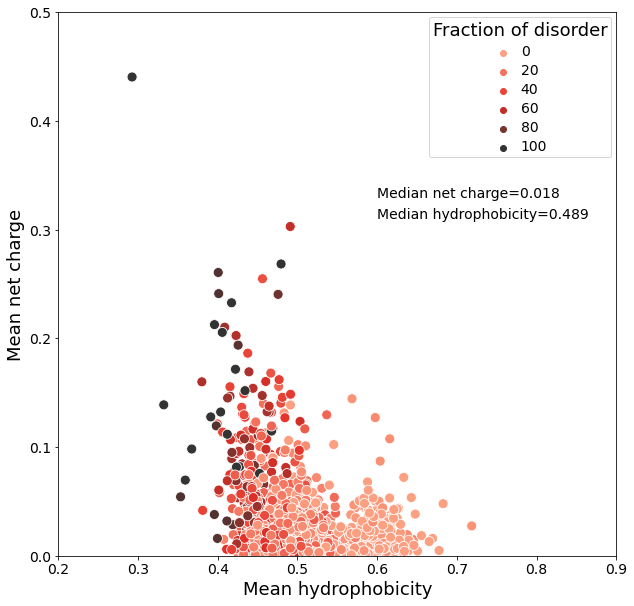

In [ ]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,10))

ax.set_xlim(0.2, 0.9)
ax.set_ylim(0, 0.5)

ax.set_ylabel('Mean net charge', fontsize=18)
ax.set_xlabel('Mean hydrophobicity', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

sns.scatterplot(data=TT_proteome, x='mean_hydrophobicity', y='mean_net_charge', hue='Fraction of disorder', s=100, palette='Reds_d')
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='18')

median_charge = TT_proteome.mean_net_charge.median()
median_hydro = TT_proteome.mean_hydrophobicity.median()

ax.text(0.6, 0.33, 'Median net charge={:.3f}'.format(median_charge), fontsize=14)
ax.text(0.6, 0.31, 'Median hydrophobicity={:.3f}'.format(median_hydro), fontsize=14)

fig.savefig('TT_proteome_chplot.svg')